# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py


import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import remainder, tau
import math
from scipy import stats
from statannotations.Annotator import Annotator
import collections
from matplotlib.colors import LinearSegmentedColormap
from astropy.stats import circcorrcoef
from sklearn.linear_model import LinearRegression
import scipy

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Params

In [3]:
GLOBALFONTSIZE = 12
LEFTCOLOR = '#FF9F1C'
RIGHTCOLOR = '#2EC4B6'
LOWERCOLOR = '#3f92e9' 
HIGHERCOLOR = '#ff5630'
GLOBALTICKWIDTH = 1.6
GLOBALTICKLENGTH = 6
GLOBALSPEEDFILTER = True 

In [4]:
boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   }) #'width': 0.75
stripplot_kwargs = dict({'linewidth': 1},) #, 'size': 5, 'alpha': 0.8

In [5]:
# Number of colors in the colormap
n_colors = 256

colors = ['#1a2a6c','#b21f1f','#fdbb2d']

modelCmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

# Create the custom colormap using LinearSegmentedColormap
cmapShortLong = LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_colors)


In [6]:
COLORSFORHEADINGLEFTRIGHT = ['#5433ff','#00dbde']

In [7]:
from matplotlib.colors import Normalize 

# Calculate the limits for the color hue
hue_min = -np.pi/5
hue_max = np.pi/5
GLOBALHUENORM = Normalize(vmin=hue_min, vmax=hue_max)

In [8]:
GLOBALCONV = True

# Data prep

In [9]:
fn = myProject.dataPath + '/results/behavior_180_EastReferenceQuadrant.csv'
res = pd.read_csv(fn)
res = res[res.valid]

In [10]:
import collections

def nested_dict():
    return collections.defaultdict(nested_dict)

In [11]:
#Loading the file
fn=myProject.dataPath+"/results/myLeverCellStatsSplitByMedian_homingDir_all.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    hdLeverCenteredLeftRightHeadingError = pickle.load(fp)  

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myLeverCellStatsSplitByMedian_homingDir_all.pickle


In [12]:
#Get Cells DataFrame

fn=myProject.dataPath+"/results/cells.csv"
gc = pd.read_csv(fn)
ct = gc.copy()

gc = gc.loc[gc["gridCell_AND"],:]

In [13]:
fn = "/adata/projects/autopi_mec/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

In [14]:
lever_gc=ct.loc[ct["gridCell_FIRST"],:]

In [15]:
fn = myProject.dataPath + '/results/allSessionDf_with_leverVector_and_last_cohort.csv'
allSessionDf = pd.read_csv(fn,index_col=0)
allSessionDf['light'] = allSessionDf['condition'].apply(lambda x: x.split('_')[1])
allSessionDf['cond_noLight'] = allSessionDf['condition'].apply(lambda x: x.split('_')[0])

In [16]:
#Flip mvtDirError
allSessionDf['mvtDirError'] = np.negative(allSessionDf['mvtDirError'])

In [17]:
dfOf = pd.read_csv(myProject.dataPath+'/results/reconstuctionDFOF.csv',index_col=0)

In [18]:
full_all_sessions = allSessionDf.copy()

In [19]:
def append_head_tail(angles):
    return np.append(angles,angles[0])
    
global_bins = [-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
       -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
       -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
       -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
        0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
        1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
        2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
        3.05432619]


def plotHdMapTogether_correct(ax,hdMap1,hdMap2,colors = [LOWERCOLOR,HIGHERCOLOR],title="",hd_score = 'Nan',titleY=0.95,max_num=15,setMaxNum = False):
    """
    Plot one 2D map
    """
    
    lw = 3
    
    ax.plot(append_head_tail(global_bins),append_head_tail(hdMap1),lw=lw,color = colors[0])
    ax.plot(append_head_tail(global_bins),append_head_tail(hdMap2),lw=lw,color = colors[1]) #,linestyle = 'dashed'

    
    ax.set_title(title,y=1.05,fontsize=9)
    if setMaxNum:
        ax.set_rlim(0,max_num+1)

    
    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_rlabel_position(0)


In [20]:
def head_direction_score_from_histo(hdHisto, bins = None):
        """
        Method to calculate the mean direction and the mean vector length from the hd-rate histogram using already saved head-direction histogram
        
        To get valid scores (not np.nan), the sum of firing rates should be larger than 0 and there should be no np.nan in the firing_rate_head_direction_histo
        
        returns a tuple: mean_direction_rad, mean_direction_deg, mean_vector_length, peak_angle_rad, peak_rate
        """
            
        # sum up all spikes
        sum_histo = np.sum(hdHisto)
        
        # if all rates are at 0 or some at np.nan, we can't calculate these scores reliably
        if sum_histo == 0.0 or np.isnan(sum_histo):
            hd_mean_vector_length= np.nan
            hd_peak_angle_rad = np.nan
            hd_peak_rate = np.nan
            hd_mean_direction_deg = np.nan
            hd_mean_direction_rad = np.nan
            return (hd_mean_direction_rad,hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate)
        
        
        # get midth of head direction bins
        if bins == None:
            angles= [-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
           -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
           -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
           -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
            0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
            1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
            2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
            3.05432619]
        else:
            angles = bins
        
        
        # get x and y component of each angle and multiply by firing rate
        x = np.cos(angles)*hdHisto
        y = np.sin(angles)*hdHisto
                
        
        # the angle is the arctan of x divided by y
        mean_direction = np.arctan2(np.sum(y),np.sum(x))
        
        # angle of the peak
        hd_peak_angle_rad = angles[np.argmax(hdHisto)]
        hd_peak_rate = np.nanmax(hdHisto)
        
        hd_mean_direction_deg = mean_direction*360/(2*np.pi)
        hd_mean_direction_rad = mean_direction
        
        #get mean vector length
        R = np.sqrt(np.sum(x)**2+np.sum(y)**2)
        hd_mean_vector_length = R/sum_histo
        hd_variance = (1. - hd_mean_vector_length) * 180.

        return (hd_mean_direction_rad,hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate)
    

# Split between left right

In [21]:
belowOrAboveList = ['aboveMedianIntervals','belowMedianIntervals']
cell_hd_dir_rad_holder = []
cell_hd_dir_deg_holder = []
cell_hd_vector_holder = []
cell_hd_peak_rad_holder = []
cell_hd_peak_rate_holder = []
cluIdList = []
medianConditionList = []
cell_hd_mean_rate = []
diff_radian_holder = []
infoHolder = []
lightHolder = []
intervalHolder = []
histoholder = []


intervalType = 'all'
lightConditionList = ['dark']
for lightCondition in lightConditionList:
    for clu in lever_gc.cluId.unique():
        for belowOrAbove in belowOrAboveList:

            histoByMedian = hdLeverCenteredLeftRightHeadingError[clu][lightCondition][intervalType][belowOrAbove]['Hist']
            cellMeanByMedian = hdLeverCenteredLeftRightHeadingError[clu][lightCondition][intervalType][belowOrAbove]['meanFiring']
            infoByMedian = hdLeverCenteredLeftRightHeadingError[clu][lightCondition][intervalType][belowOrAbove]['infoScore']

            try:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = hdLeverCenteredLeftRightHeadingError[clu][lightCondition][intervalType][belowOrAbove]['hd_score']
            except:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = [np.nan]*5

            cluIdList.append(clu)
            medianConditionList.append(belowOrAbove)
            infoHolder.append(infoByMedian)
            cell_hd_dir_rad_holder.append(cell_hd_dir_rad)
            cell_hd_dir_deg_holder.append(cell_hd_dir_deg)
            cell_hd_vector_holder.append(cell_hd_vector)
            cell_hd_peak_rad_holder.append(cell_hd_peak_rad)
            cell_hd_peak_rate_holder.append(cell_hd_peak_rate)
            cell_hd_mean_rate.append(cellMeanByMedian)
            lightHolder.append(lightCondition)
            intervalHolder.append(intervalType)
            histoholder.append(histoByMedian)

In [22]:
dfMedianSplitLR = pd.DataFrame(list(zip(cluIdList,medianConditionList,lightHolder,infoHolder,cell_hd_dir_rad_holder,
                                          cell_hd_dir_deg_holder,cell_hd_vector_holder,cell_hd_peak_rad_holder,
                                          cell_hd_peak_rate_holder,cell_hd_mean_rate,intervalHolder)),
                 columns = ['cluId','medianCondition','lightCondition','infoScore',
                            'hd_dir_rad','hd_dir_deg','hd_vector','hd_peak_rad','hd_peak_rate','hd_mean_rate','intervalType'])

In [23]:
dfMedianSplitLR['sessionName'] = dfMedianSplitLR['cluId'].apply(lambda x: x.split('_')[0])

In [24]:
splitVariable='medianMVDeviationRoomReference'

dfHolder = []
for sesName in res.sessionName.unique():
    for lightCondition in res.light.unique():
        res_dfSlice = res[(res.light == lightCondition)&(res.sessionName == sesName)]
        
        homingPeriMedianSlice = res_dfSlice[splitVariable].median()
        res_dfSlice = res_dfSlice.dropna(subset=splitVariable)
        res_dfSlice['belowMedian'] = np.where(res_dfSlice[splitVariable]<homingPeriMedianSlice, 'belowMedianIntervals', 'aboveMedianIntervals')
        dfHolder.append(res_dfSlice)

In [25]:
resHeadingError = pd.concat(dfHolder)

In [26]:
var = 'medianMVDeviationRoomReference'
def mySummary(df):        
    error = np.nanmean(df[f"{var}"])        
    return pd.DataFrame({f"{var}": [error]})
  
resHeadingErrorSession = resHeadingError.groupby(['sessionName','belowMedian','light']).apply(mySummary).reset_index()

In [27]:
dfMedianSplitLR = pd.merge(dfMedianSplitLR,resHeadingErrorSession,how='left',left_on=['sessionName','medianCondition','lightCondition'],right_on=['sessionName','belowMedian','light'])
dfMedianSplitLR['mouse'] = dfMedianSplitLR['cluId'].apply(lambda x: x.split('-')[0])

In [28]:
histoDf = pd.DataFrame(np.array(histoholder),columns = [f'histo_bin_{j+1}' for j in range(36)])

In [29]:
dfMedianSplitLR = pd.concat([dfMedianSplitLR,histoDf],axis=1)

In [30]:
exclude_cluIds = list(dfMedianSplitLR[dfMedianSplitLR.hd_vector.isnull()]['cluId'])
dfMedianSplitLR = dfMedianSplitLR[~dfMedianSplitLR['cluId'].isin(exclude_cluIds)].reset_index(drop=True)

# Processing functions

In [31]:
def interpolate_histogram(hist):
    # Find the indices of NaN values in the histogram
    nan_indices = np.isnan(hist)

    # Create an array of indices from 0 to the length of the histogram
    indices = np.arange(len(hist))

    # Interpolate using neighboring values
    hist[nan_indices] = np.interp(indices[nan_indices], indices[~nan_indices], hist[~nan_indices])

    return hist

In [32]:
def homing_angle_corr_stats(x,y,signLevel=0.025):       
    realR = circcorrcoef(x,y)
    anglesCentered = centerAngles(x)
    model = LinearRegression()
    model.fit(anglesCentered[:,np.newaxis],y)
    slope = model.coef_[0]

    xr = x.copy()

    n = 10000
    shufR = np.zeros(n)

    for i in range(n):
        np.random.shuffle(xr)
        shufR[i] = circcorrcoef(xr,y)
    signPlus = np.quantile(shufR,1-signLevel)
    signMinus = np.quantile(shufR,signLevel)
    
    if realR < signMinus or realR > signPlus:
        return ( realR, slope, np.nanmean(shufR), True)
    else:
        return ( realR, slope, np.nanmean(shufR), False)

In [33]:
def centerAngles(a):
    """
    Center angles on their circular mean
    """
    b = a - np.arctan2(np.sum(np.sin(a)),np.sum(np.cos(a))) # values - circular mean
    return np.arctan2(np.sin(b),np.cos(b)) # set the range between -pi to pi)  

In [34]:
import math
import scipy


def get_circular_mean_shift_rad(hist, fromCenter=True, convolution=False, shiftedMeanArray=None, gaus=True):
    
    # Apply convolution or smoothing if required
    if convolution:
        if gaus:
            hist = smooth_heatmap(hist)
        elif shiftedMeanArray is not None:
            hist = np.correlate(hist, shiftedMeanArray, mode='same')
        else:
            raise ValueError("shiftedMeanArray must be provided if gaus is False.")

    # Number of bins
    num_bins = len(hist)
    
    # Calculate the width of each bin
    bin_width = 2 * np.pi / num_bins
    
    # Generate the angle for each bin center
    angles = np.linspace(-np.pi, np.pi - bin_width, num_bins)
    
    # Compute the sine and cosine components weighted by the histogram counts
    sin_sum = np.sum(hist * np.sin(angles))
    cos_sum = np.sum(hist * np.cos(angles))
    
    # Calculate the circular mean using atan2 to get the correct quadrant
    circular_mean = math.atan2(sin_sum, cos_sum)
    
    # Normalize the result to be within [-pi, pi]
    circular_mean = math.remainder(circular_mean, 2 * math.pi)
    
    return circular_mean

def get_shift_index_model(hist1,hist2):
    corrHolder = []
    for i in range(len(hist1)):
        rolledCor, _ = scipy.stats.pearsonr(hist1,np.roll(hist2,i))
        corrHolder.append(rolledCor)
       
    return get_circular_mean_shift_rad(corrHolder)   


In [35]:
def get_trial_model_shift(combinedDf,res = res, lightCondition = 'dark',sesName = ''):
    searchHolder = []
    homingHolder = []
    homingToSearchHolder = []
    trialHolder =[]
    searchRadHolder = []
    atLeverRadHolder = []
    homingRadHolder = []
    
    dfOfSlice = dfOf[dfOf.session == sesName].copy()
    histosFromOf = get_histos_per_trial(dfOfSlice)
    combinedDf = filterForConditions(combinedDf,lightCondition)
    

    for trial in combinedDf[combinedDf.light==lightCondition].trialNo.unique():

            trialSlice = combinedDf[combinedDf.trialNo == trial].copy()

            plotSlice = trialSlice[trialSlice.condition == f'searchToLeverPath_{lightCondition}'].copy()
            

            
            hist_search = plotSlice.iloc[:,-36:].values.squeeze()
            searchRad = get_circular_mean_shift_rad(hist_search,fromCenter=True,convolution=GLOBALCONV,shiftedMeanArray=histosFromOf)
           

            plotSlice = trialSlice[trialSlice.condition == f'atLever_{lightCondition}'].copy()
            hist_lever = plotSlice.iloc[:,-36:].values.squeeze()

            atLeverRad = get_circular_mean_shift_rad(hist_lever,fromCenter=True,convolution=GLOBALCONV,shiftedMeanArray=histosFromOf)

            plotSlice = trialSlice[trialSlice.condition == f'homingFromLeavingLeverToPeriphery_{lightCondition}'].copy()
            hist_homing =  plotSlice.iloc[:,-36:].values.squeeze()

            homingRad = get_circular_mean_shift_rad(hist_homing,fromCenter=True,convolution=GLOBALCONV,shiftedMeanArray=histosFromOf)

            shiftIndexSearch = get_shift_index_model(hist_search,hist_lever)
            shiftIndexHoming = get_shift_index_model(hist_lever,hist_homing)
            shiftIndexHomingToSearch = get_shift_index_model(hist_search,hist_homing)
           
           
            searchHolder.append(shiftIndexSearch)
            homingHolder.append(shiftIndexHoming)
            homingToSearchHolder.append(shiftIndexHomingToSearch)

            searchRadHolder.append(searchRad)
            atLeverRadHolder.append(atLeverRad)
            homingRadHolder.append(homingRad)
            trialHolder.append(trial)


    trialModelShift = pd.DataFrame({'trialNo':trialHolder,'search':searchHolder,'searchRad':searchRadHolder,'homing':homingHolder,'atLeverRad':atLeverRadHolder
                                ,'homingToSearch':homingToSearchHolder,'homingRad':homingRadHolder})
   
    trialModelShift['sessionName'] = sesName
    trialModelShift['light'] = lightCondition

    trialModelShift = pd.merge(trialModelShift,res,how='left',on=['sessionName','light','trialNo'])

    trialModelShift['homingDir'] = np.radians(trialModelShift['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    trialModelShift['homingDir'] = centerAngles(trialModelShift['homingDir'])

    print('Original Shape for session ', sesName, ' is ', len(combinedDf[combinedDf.light==lightCondition].trialNo.unique()))
    print('Shape for session ', sesName, ' is ', trialModelShift.shape)

    return trialModelShift

In [36]:
def get_circular_stats_dataFrame(sessionName,inputDf,res = res.copy(),lightCondition = 'dark',speedFilter=GLOBALSPEEDFILTER):
   
    sessionSlice = inputDf[inputDf.session == sessionName].copy().reset_index()
    
    if speedFilter:
        sessionSlice = sessionSlice[(sessionSlice.speed > 10)].copy()

   
    combinedDf = get_combinedDf(sessionSlice,res=res.copy(),sesName = sessionName)
    combinedDf = combinedDf.dropna().copy()
   
    trialModelShift =  get_trial_model_shift(combinedDf,res.copy(),lightCondition = lightCondition,sesName = sessionName)


    trialModelShift = trialModelShift.dropna()

    return trialModelShift

In [37]:
def filterForConditions(inputDf,lightCondition = 'dark'):
    #This step is to make sure we only use trials that has search, at lever, and homing at the same time
    
    # Define the conditions you want to check for
    desired_conditions = [f'atLever_{lightCondition}', f'searchToLeverPath_{lightCondition}', f'homingFromLeavingLeverToPeriphery_{lightCondition}']

    # Group the DataFrame by 'trial' and check if all desired conditions exist in each group
    filtered_trials = inputDf.groupby('trialNo')['condition'].apply(lambda x: all(c in x.values for c in desired_conditions))

    # Get the trial IDs that meet the condition
    selected_trials = filtered_trials[filtered_trials].index

    # Filter the original DataFrame based on the selected trial IDs
    result_df = inputDf[inputDf['trialNo'].isin(selected_trials)].copy()
    
    return result_df

In [38]:
def getModelHistosByMedian(sesName,condition):
    testDf = getDfBySesName(sesName).copy()

    testDf['homingDir'] = np.radians(testDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    testDf['homingDir'] = centerAngles(testDf['homingDir'])
    testDf = filterForConditions(testDf).copy()

    dfOfSlice = dfOf[dfOf.session == sesName].copy()
    histosFromOf = get_histos_per_trial(dfOfSlice)

    inputLS = testDf[testDf.condition == condition].copy()
    inputLS = inputLS.sort_values(by='homingDir',ascending=True)

    plotArray, maxInd = get_trial_drift_from_slice_ls(inputLS,getMatrix=True,shiftedMeanArray=histosFromOf,sortCondition='homingDir',convolution=GLOBALCONV)


    plotArray = normalize_2d_array(plotArray)
    
    medianInd = len(plotArray)//2
    
    firstHalf = np.nansum(plotArray[:medianInd,:],axis=0)
    secondHalf = np.nansum(plotArray[medianInd:,:],axis=0)
    
    return firstHalf, secondHalf

In [39]:
def center_on_lever(inputDf):
    inputDf = transform_coord(inputDf).copy()
    dfH = []
    for t in inputDf.trialNo.unique():
        testSlice = inputDf[inputDf.trialNo == t].copy()
        testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y']) 
        testSlice['pathCenterOnLever_y'] = testSlice['yPose'] - np.nanmean(testSlice['leverY_y'])

        testSlice['pred_pathCenterOnLever_x'] = testSlice['ActualCoordpx'] - np.nanmean(testSlice['leverX_y'])
        testSlice['pred_pathCenterOnLever_y'] = testSlice['ActualCoordpy'] - np.nanmean(testSlice['leverY_y'])

        dfH.append(testSlice)

    dfH = pd.concat(dfH)

    return dfH

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d


def smooth_heatmap(heatmap, sigma=1, ksize=6):
    # Create a Gaussian kernel with the desired standard deviation
    size = int(ksize * sigma)
    gaussian_kernel = gaussian(2 * size + 1, sigma)
   
    # Normalize the kernel so that the sum of its elements is 1
    gaussian_kernel /= gaussian_kernel.sum()
   
    if heatmap.ndim == 1:
        # If it's a 1D array, convert it to a 2D array with one row
        heatmap = np.atleast_2d(heatmap)
   
    # Perform convolution along the specified axis
    smoothed_heatmap = convolve1d(heatmap, gaussian_kernel, mode='wrap', axis=1)
   
    return smoothed_heatmap.squeeze()

In [41]:
def calculatePvalue(Pvalue):
    """
    Calculate the symbol to plot based on the given p-value.

    Parameters:
        Pvalue (float): The p-value to calculate the symbol for.

    Returns:
        str: The symbol to plot based on the p-value.
    """

    
    if Pvalue < 0.0001:
        symbolToPlot = '****'
    elif Pvalue < 0.001:
        symbolToPlot = '***'
    elif Pvalue < 0.01:
        symbolToPlot = '**'
    elif Pvalue < 0.05:
        symbolToPlot = '*'
    else:
        symbolToPlot = 'ns'

    return symbolToPlot

In [42]:
def getHomingColorPath(sName):
    inputDf = full_all_sessions.copy() 

    sessionSlice = inputDf[inputDf.session == sName].reset_index()
    sessionSlice['sessionName'] = sessionSlice['session']
    sessionSlice = pd.merge(sessionSlice,res.copy(),how='left',on=['sessionName','trialNo','light'])

    sessionSlice['homingDir'] = np.radians(sessionSlice['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    sessionSlice['homingDir'] = centerAngles(sessionSlice['homingDir'])

    return sessionSlice

In [43]:
def getSessionSlice(sesName = 'jp452-25112022-0110',speedFilter= GLOBALSPEEDFILTER):
    sessionSlice = allSessionDf[allSessionDf.session == sesName].copy()
    if speedFilter:
        sessionSlice = sessionSlice[(sessionSlice.speed > 10) ].reset_index().copy()
    return sessionSlice

In [44]:
def get_merge_dataframe(navPathSummary,mergeDf):
    #Get a merged dataframe from the navPathSummary with the Behavioral performance dataframe
    navPathSummary['nJourneys'] = navPathSummary['journey'] + 1
    
    #Load the performance dataframe
    smaller_trial_df = mergeDf.copy() #If you don't use copy, this will also make changes on the original res dataframe

    #Merge the performance dataframe with the Navpath dataframe
    merged_df = navPathSummary.merge(smaller_trial_df,how = 'left', left_on = ['trial','light','nJourneys'],right_on = ['name','light','nJourneys'])
    
    #Exclude all the NaNs in the dataframe
    merged_df = merged_df[~merged_df.homingErrorAtPeripheryLever.isna()].reset_index(drop=True)
    
    #Make sure all trials are valid
    merged_df = merged_df[merged_df.valid].reset_index(drop=True)
    
    return merged_df

In [45]:
def apply_z_score(plotArray):
    row_mean = np.mean(plotArray, axis=1)
    row_std = np.std(plotArray, axis=1)

    # Perform the Z-score transformation
    plotArray = (plotArray - row_mean[:, np.newaxis]) / row_std[:, np.newaxis]

    return plotArray

def normalize_2d_array(arr):
    """
    Normalize the values in each row of a 2D array to the range [0, 1].

    Parameters:
    arr (list of lists): The input 2D array.

    Returns:
    np.ndarray: The normalized 2D array.
    """
    # Convert the input list of lists to a NumPy array
    np_arr = np.array(arr, dtype=float)

    # Find the minimum and maximum values along each row
    min_vals = np.min(np_arr, axis=1, keepdims=True)
    max_vals = np.max(np_arr, axis=1, keepdims=True)

    # Ensure there are no divisions by zero
    max_vals[max_vals == min_vals] = 1

    # Normalize the array to the range [0, 1]
    normalized_arr = (np_arr - min_vals) / (max_vals - min_vals)

    return normalized_arr

In [46]:
def get_trial_drift_from_slice_ls(inputDf,getMatrix=False,shiftedMeanArray=None,sortCondition='',convolution=True,gaus=True):
    if len(sortCondition) == 0:
        sortSlice = inputDf.copy()
    else:
        sortSlice = inputDf.sort_values(by=sortCondition,ascending=True)
    
    corArrayHolder = []
    interHolder = []

    shiftIndex = np.argmax(np.nanmean(sortSlice.iloc[:,-37:-1],axis=0))

    for i in range(0,sortSlice.shape[0]):

        heatmapSlice = np.array(sortSlice.iloc[i,-37:-1]).astype(float)

        heatmapSlice = interpolate_histogram(heatmapSlice)
        heatmapSlice = np.roll(heatmapSlice,18-shiftIndex) #This centers the array
        
        if gaus:
            crossCor = smooth_heatmap(heatmapSlice)
        else:
            crossCor = np.correlate(heatmapSlice,shiftedMeanArray,mode='same')
            
        corArrayHolder.append(crossCor)
        interHolder.append(heatmapSlice)

    if convolution:
        pass
    else:
        corArrayHolder = interHolder
        
    driftIndex = np.argmax(corArrayHolder,axis=1) - 18 #Calculate the shift from the center

    if getMatrix:
        return corArrayHolder,np.argmax(corArrayHolder,axis=1)
   
    shiftDegree = driftIndex*10

    radians = np.radians(shiftDegree)


    def wrap_radians(arr,divisor=math.tau):
        r_func = np.vectorize(lambda x: math.remainder(x,divisor))

        return r_func(arr)
    
    radians = wrap_radians(radians)
    radians = centerAngles(radians)
   
    return radians

In [47]:
def get_trial_drift_from_slice_ls_circ_mean(
    inputDf,
    getMatrix=False,
    shiftedMeanArray=None,
    sortCondition='',
    convolution=True,
    gaus=True,
    circ_mean_or_peak='peak'  # New parameter as the reviewer requested
):

    # Validate circ_mean_or_peak parameter
    if circ_mean_or_peak not in ['peak', 'circular_mean']:
        raise ValueError("circ_mean_or_peak must be either 'peak' or 'circular_mean'.")

    # Sort the DataFrame if a sort condition is provided
    if len(sortCondition) == 0:
        sortSlice = inputDf.copy()
    else:
        sortSlice = inputDf.sort_values(by=sortCondition, ascending=True)

    corArrayHolder = []
    interHolder = []

    # Determine the shift index based on the mean of histograms
    shiftIndex = np.argmax(np.nanmean(sortSlice.iloc[:, -37:-1], axis=0))

    for i in range(sortSlice.shape[0]):
        # Extract and process the histogram slice
        heatmapSlice = np.array(sortSlice.iloc[i, -37:-1]).astype(float)
        heatmapSlice = interpolate_histogram(heatmapSlice)
        heatmapSlice = np.roll(heatmapSlice, 18 - shiftIndex)  # Center the array

        # Apply smoothing or correlation
        if gaus:
            crossCor = smooth_heatmap(heatmapSlice)
        else:
            if shiftedMeanArray is None:
                raise ValueError("shiftedMeanArray must be provided if gaus is False.")
            crossCor = np.correlate(heatmapSlice, shiftedMeanArray, mode='same')
        
        corArrayHolder.append(crossCor)
        interHolder.append(heatmapSlice)


    if not convolution:
        corArrayHolder = interHolder

    corArrayHolder = np.array(corArrayHolder)  # Convert to NumPy array for vectorized operations

    if circ_mean_or_peak == 'peak':
        # Calculate shift index based on the peak
        shiftIndices = np.argmax(corArrayHolder, axis=1) 
    elif circ_mean_or_peak == 'circular_mean':
        # Calculate shift index based on the circular mean
        num_bins = corArrayHolder.shape[1]
        bin_width = 2 * np.pi / num_bins
        angles = np.linspace(-np.pi, np.pi - bin_width, num_bins)

        # Compute sine and cosine weighted by histogram counts
        sin_components = np.sin(angles)  # Shape: (num_bins,)
        cos_components = np.cos(angles)  # Shape: (num_bins,)

        # Broadcast and multiply
        sin_sum = np.dot(corArrayHolder, sin_components)  # Shape: (num_samples,)
        cos_sum = np.dot(corArrayHolder, cos_components)  # Shape: (num_samples,)

        # Calculate circular mean angles using atan2
        circular_mean_angles = np.arctan2(sin_sum, cos_sum)  # Shape: (num_samples,)

        # Convert angles to shift indices

        shiftIndices = (circular_mean_angles / bin_width) + 18


    # If getMatrix is True, return the correlation array and shift indices
    if getMatrix:
        return corArrayHolder, shiftIndices

    # Convert shift indices to degrees
    shiftDegree = shiftIndices * 10  # Assuming each shift index corresponds to 10 degrees

    # Convert degrees to radians
    radians = np.radians(shiftDegree)

    # Define a helper function to wrap radians within [0, 2π)
    def wrap_radians(arr, divisor=2 * math.pi):
        return np.mod(arr, divisor)

    radians = wrap_radians(radians)
    radians = centerAngles(radians)  # Center angles within [-π, π]

    return radians

In [48]:
def get_combinedDf(sessionSlice,res=res,sesName = ''):
    condHolder = []
    trialHolder = []
    mvlHolder = []
    histosHolder = []
    dfHolder = []
    for cond in sessionSlice.condition.unique():
        for t in sessionSlice[sessionSlice.condition == cond].trialNo.unique():
            sliceDf = sessionSlice[(sessionSlice.condition == cond)&(sessionSlice.trialNo == t)].copy()
            histos = get_histos_per_trial(sliceDf)
            histosHolder.append(histos)

            # Step 3: Convert to complex numbers
            complex_data = np.exp(1j * sliceDf['mvtDirError'])

            # Step 4: Calculate the mean vector
            mean_vector = np.mean(complex_data)

            # Step 5: Calculate the mean vector length
            mean_vector_length = np.abs(mean_vector)

            condHolder.append(cond)
            trialHolder.append(t)
            mvlHolder.append(mean_vector_length)

    histosDf = pd.DataFrame(histosHolder,columns=[f'bin_{i}' for i in range(1,37)])

    combinedDf = pd.DataFrame({'condition':condHolder,'trialNo':trialHolder,'mvl':mvlHolder})
    combinedDf['sessionName'] = sesName
    combinedDf['light'] = combinedDf.condition.apply(lambda x: x.split('_')[1])
    combinedDf = pd.merge(combinedDf,res,how='left',on=['sessionName','trialNo','light'])

    combinedDf = pd.concat([combinedDf,histosDf],axis=1)
    combinedDf = combinedDf[combinedDf.valid == True]
    return combinedDf

In [49]:
# Transform the grid coordinates to the actual coordinates
# This can only be used after the sessionSlice is defined
#Transform the coordinates x,y (These would be the same as the animalPose)
def transform_coord(full_df):
    for i in tqdm(full_df.trialNo.unique()):
        startPointX = full_df.loc[full_df.trialNo == i]['xPose'].values[0]
        cumsumX = full_df.loc[full_df.trialNo == i]['x']
        startPointY = full_df.loc[full_df.trialNo == i]['yPose'].values[0]
        cumsumY = full_df.loc[full_df.trialNo == i]['y']
        full_df.loc[full_df.trialNo == i,'ActualCoordx'] = np.cumsum(cumsumX)+startPointX
        full_df.loc[full_df.trialNo == i,'ActualCoordy'] = np.cumsum(cumsumY)+startPointY

    #Transform the Predicted
    for i in tqdm(full_df.trialNo.unique()):
            startPointX = full_df.loc[full_df.trialNo == i]['xPose'].values[0]
            cumsumX = full_df.loc[full_df.trialNo == i]['px']
            startPointY = full_df.loc[full_df.trialNo == i]['yPose'].values[0]
            cumsumY = full_df.loc[full_df.trialNo == i]['py']
            full_df.loc[full_df.trialNo == i,'ActualCoordpx'] = np.cumsum(cumsumX)+startPointX
            full_df.loc[full_df.trialNo == i,'ActualCoordpy'] = np.cumsum(cumsumY)+startPointY

    return full_df

In [50]:
def getDfBySesName(sessionName,speedFilter= GLOBALSPEEDFILTER):
    inputDf = full_all_sessions.copy() 
    sessionSlice = inputDf[inputDf.session == sessionName].reset_index()
    if speedFilter:
        sessionSlice = sessionSlice[(sessionSlice.speed > 10)]

    combinedDf = get_combinedDf(sessionSlice.copy(),res=res.copy(),sesName = sessionName).copy()

    combinedDf.insert(0,'sumOfHistos',np.nansum(combinedDf.iloc[:,-36:].values,axis=1))

    return combinedDf

In [51]:
def splitShortLong(testDf):

    dfHolder = []
    for l in testDf.light.unique():
        medianSearchLength = testDf[testDf.light == l].searchLength.median()
        testDfLight = testDf[testDf.light == l].copy()
        testDfLight['splitMedianCondition'] = testDfLight.searchLength.apply(lambda x: 'short' if x < medianSearchLength else 'long')
        dfHolder.append(testDfLight)

    testDf = pd.concat(dfHolder)
    return testDf

In [52]:
def prepareTrialDfBinned(sName,t,speedFilter = GLOBALSPEEDFILTER):
    workingDf = splitShortLong(getDfBySesName(sName))

    trials = workingDf[(workingDf.light =='dark')&(workingDf.splitMedianCondition == 'long')].trialNo.unique()

    inputDf = full_all_sessions.copy() 

    sessionSlice = inputDf[inputDf.session == sName].reset_index()
    
    if speedFilter:
        sessionSlice = sessionSlice[(sessionSlice.speed > 10)] 
    
    sessionSliceT = sessionSlice[(sessionSlice.condition=='searchToLeverPath_dark') & (sessionSlice.trialNo == t)].copy()
    sessionSliceT = transform_coord(sessionSliceT)
    
     # Calculate quartiles
    quartile_1 = sessionSliceT['withinPathTime'].quantile(0.25)
    quartile_2 = sessionSliceT['withinPathTime'].quantile(0.5)  # This is the median
    quartile_3 = sessionSliceT['withinPathTime'].quantile(0.75)

    # Create a new column 'withinTrialSplit' based on the quartiles
    sessionSliceT['withinTrialSplit'] = np.where(sessionSliceT['withinPathTime'] <= quartile_1, 'Q1',
                                np.where(sessionSliceT['withinPathTime'] <= quartile_2, 'Q2',
                                np.where(sessionSliceT['withinPathTime'] <= quartile_3, 'Q3', 'Q4')))
    
    return sessionSliceT


In [53]:
def remove_all_ticks(ax):
    """
    Remove all ticks from the given axis.

    Parameters:
        ax (matplotlib.axis.Axis): The axis object from which ticks will be removed.

    Returns:
        None
    """
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.set_xlabel('',fontsize=GLOBALFONTSIZE)
    #ax.set_ylabel('',fontsize=GLOBALFONTSIZE)

def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [54]:
from sklearn.linear_model import LinearRegression
from astropy.stats import circcorrcoef


degPerBin = 10
bin_edges = np.arange(-np.pi,np.pi+degPerBin/360*2*np.pi,degPerBin/360*2*np.pi)

def get_histos_per_trial(inputDf,bin_edges = bin_edges,num_bins=36,bin_var='mvtDirError'):
    # Use np.digitize to assign values to bins
    inputDf['bins'] = np.digitize(inputDf[bin_var], bin_edges)

    # Calculate and print the bin counts
    bin_counts = inputDf['bins'].value_counts().sort_index()

    # Create an array of length 1x36 with bin counts
    counts_array = np.zeros(num_bins, dtype=int)
    for bin_idx in range(1, num_bins + 1):
        count = bin_counts.get(bin_idx, 0)
        counts_array[bin_idx - 1] = count

    return counts_array

In [55]:
import pandas as pd
import numpy as np

def getOriginalDataframeWithTrialSplit(sName, speedFilter= GLOBALSPEEDFILTER):
    workingDf = splitShortLong(getDfBySesName(sName))
    trials = workingDf[(workingDf.light =='dark')&(workingDf.splitMedianCondition == 'long')].trialNo.unique()

    inputDf = full_all_sessions.copy()
    sessionSlice = inputDf[inputDf.session == sName].reset_index()
    if speedFilter:
        sessionSlice = sessionSlice[(sessionSlice.speed > 10) ] 

    sessionHolder = []
    for t in trials:
        sessionSliceT = sessionSlice[(sessionSlice.condition=='searchToLeverPath_dark') & (sessionSlice.trialNo == t)].copy()

        # Calculate quartiles using vectorized operation
        quartiles = sessionSliceT['withinPathTime'].quantile([0.25, 0.5, 0.75])
        
        # Create a new column 'withinTrialSplit' based on the quartiles using NumPy's select function
        conditions = [sessionSliceT['withinPathTime'] <= quartiles[0.25],
                      sessionSliceT['withinPathTime'] <= quartiles[0.5],
                      sessionSliceT['withinPathTime'] <= quartiles[0.75]]
        choices = ['Q1', 'Q2', 'Q3']
        sessionSliceT['withinTrialSplit'] = np.select(conditions, choices, default='Q4')

        sessionHolder.append(sessionSliceT)

    return pd.concat(sessionHolder)

In [56]:
def get_model_time_bin(inputDf,speedFilter=GLOBALSPEEDFILTER):
    binWidth = 2
    maxBin=4
    minSpeed = 10


    inputDf["timeBin"] = np.floor(inputDf.withinPathTime/binWidth)
    dfAutoPISel = inputDf[(inputDf.condition=="searchToLeverPath_dark")].copy()
    
    if speedFilter:
        dfAutoPISel = dfAutoPISel[(dfAutoPISel.speed > minSpeed)].copy() 
    # select the dark path
    
    dfAutoPISel = dfAutoPISel[dfAutoPISel.session.isin(useAble)]

    dfAutoPISel = dfAutoPISel[dfAutoPISel.timeBin<=maxBin]
    dfAutoPISel["timeBinName"] = [ "{:.0f}".format((tb*2)+1) for tb in dfAutoPISel["timeBin"]]


    error_name = 'absMvtDirError'
    def mySummary(df):
        error = np.nanmedian(df[f"{error_name}"])
        return pd.DataFrame({"absMvtDirError": [error]})

    dfAutoPISel = dfAutoPISel.groupby(['session','condition','timeBinName']).apply(mySummary).reset_index()
    return dfAutoPISel

In [57]:
def extract_long_short_drift_stats():
    conditionFilter = 'atLever_dark'
    
    sesH = []
    shortH = []
    longH = []
    for s1 in tqdm(useAble):
        testDf = splitShortLong(getDfBySesName(s1))
        shortDf = testDf[testDf.splitMedianCondition == 'short']
        longDf = testDf[testDf.splitMedianCondition == 'long']
        
        dfOfSlice = dfOf[dfOf.session == s1]
        histosFromOf = get_histos_per_trial(dfOfSlice)
        
        shortAtLever = shortDf[shortDf.condition == conditionFilter]
        longAtLever = longDf[longDf.condition == conditionFilter]
        
        mShortDrift = get_trial_drift_from_slice_ls(shortAtLever, getMatrix=False, shiftedMeanArray=histosFromOf, convolution=GLOBALCONV)
        mLongDrift = get_trial_drift_from_slice_ls(longAtLever, getMatrix=False, shiftedMeanArray=histosFromOf, convolution=GLOBALCONV)
        
        sesH.append(s1)
        shortH.append(np.nanmean(np.abs(mShortDrift)))
        longH.append(np.nanmean(np.abs(mLongDrift)))
    
    driftStatsLongShort = pd.DataFrame({'sessionName': sesH, 'short': shortH, 'long': longH})
    
    driftStatsLongShortM = driftStatsLongShort.melt(id_vars=['sessionName'], var_name='splitMedianCondition', value_name='meanDrift')
    
    driftStatsLongShortM['mouse'] = driftStatsLongShortM['sessionName'].apply(lambda x: x.split('-')[0])
    driftStatsLongShortM['condition'] = conditionFilter
    
    return driftStatsLongShortM

In [58]:
def get_circ_stats_based_on_condition(inputDf,elements = 'homingDir',shiftCondition = 'atLeverRad'):
    inputX = inputDf[shiftCondition].values
    inputY = inputDf[elements].values

    realR, slope, shuffleR, TruOrNot = homing_angle_corr_stats(inputX,inputY)

    return realR, slope, shuffleR, TruOrNot

In [59]:
sessionList = useAble

sessionNameHolder = []
rrHolder = []
slopeHolder = []
sigHolder = []
shuffleHolder = []
shiftConditionHolder = []
gridCellHolder = []
shiftConditionList = ['searchRad','atLeverRad','homingRad']

for sesName in tqdm(sessionList):
    trialModelShift = get_circular_stats_dataFrame(sesName,allSessionDf.copy(),res.copy(),lightCondition = 'dark')
   
    for shiftCondition in shiftConditionList:
       

            realR, slope, shuffleR,sigN = get_circ_stats_based_on_condition(trialModelShift, elements = 'homingDir',shiftCondition = shiftCondition) #homingDir
            gridCellNumber  = gc[gc.session == sesName].shape[0]
       
            sessionNameHolder.append(sesName)
            shiftConditionHolder.append(shiftCondition)
            rrHolder.append(realR)
            slopeHolder.append(slope)
            shuffleHolder.append(shuffleR)
            sigHolder.append(sigN)
            gridCellHolder.append(gridCellNumber)

  0%|          | 0/24 [00:00<?, ?it/s]

Original Shape for session  jp486-19032023-0108  is  24
Shape for session  jp486-19032023-0108  is  (24, 37)


  4%|▍         | 1/24 [00:07<02:58,  7.75s/it]

Original Shape for session  jp486-18032023-0108  is  50
Shape for session  jp486-18032023-0108  is  (50, 37)


  8%|▊         | 2/24 [00:19<03:47, 10.36s/it]

Original Shape for session  jp3269-28112022-0108  is  46
Shape for session  jp3269-28112022-0108  is  (46, 37)


 12%|█▎        | 3/24 [00:32<03:58, 11.34s/it]

Original Shape for session  jp486-16032023-0108  is  52
Shape for session  jp486-16032023-0108  is  (52, 37)


 17%|█▋        | 4/24 [00:43<03:46, 11.32s/it]

Original Shape for session  jp452-25112022-0110  is  29
Shape for session  jp452-25112022-0110  is  (29, 37)


 21%|██        | 5/24 [00:52<03:16, 10.32s/it]

Original Shape for session  jp486-24032023-0108  is  40
Shape for session  jp486-24032023-0108  is  (40, 37)


 25%|██▌       | 6/24 [01:02<03:02, 10.15s/it]

Original Shape for session  jp486-22032023-0108  is  39
Shape for session  jp486-22032023-0108  is  (39, 37)


 29%|██▉       | 7/24 [01:11<02:49,  9.95s/it]

Original Shape for session  jp452-24112022-0109  is  31
Shape for session  jp452-24112022-0109  is  (31, 37)


 33%|███▎      | 8/24 [01:20<02:34,  9.64s/it]

Original Shape for session  jp486-15032023-0108  is  38
Shape for session  jp486-15032023-0108  is  (38, 37)


 38%|███▊      | 9/24 [01:30<02:24,  9.64s/it]

Original Shape for session  jp3120-25052022-0107  is  43
Shape for session  jp3120-25052022-0107  is  (43, 37)


 42%|████▏     | 10/24 [01:40<02:15,  9.69s/it]

Original Shape for session  jp3120-26052022-0107  is  30
Shape for session  jp3120-26052022-0107  is  (30, 37)


 46%|████▌     | 11/24 [01:48<02:01,  9.36s/it]

Original Shape for session  jp451-28102022-0108  is  39
Shape for session  jp451-28102022-0108  is  (39, 37)


 50%|█████     | 12/24 [01:59<01:57,  9.78s/it]

Original Shape for session  jp486-20032023-0108  is  45
Shape for session  jp486-20032023-0108  is  (45, 37)


 54%|█████▍    | 13/24 [02:10<01:52, 10.21s/it]

Original Shape for session  jp486-06032023-0108  is  39
Shape for session  jp486-06032023-0108  is  (39, 37)


 58%|█████▊    | 14/24 [02:21<01:42, 10.29s/it]

Original Shape for session  jp486-26032023-0108  is  45
Shape for session  jp486-26032023-0108  is  (45, 37)


 62%|██████▎   | 15/24 [02:31<01:34, 10.47s/it]

Original Shape for session  jp486-17032023-0108  is  54
Shape for session  jp486-17032023-0108  is  (54, 37)


 67%|██████▋   | 16/24 [02:43<01:26, 10.81s/it]

Original Shape for session  jp451-29102022-0108  is  34
Shape for session  jp451-29102022-0108  is  (34, 37)


 71%|███████   | 17/24 [02:53<01:14, 10.64s/it]

Original Shape for session  jp451-30102022-0108  is  39
Shape for session  jp451-30102022-0108  is  (39, 37)


 75%|███████▌  | 18/24 [03:03<01:01, 10.25s/it]

Original Shape for session  jp486-10032023-0108  is  47
Shape for session  jp486-10032023-0108  is  (47, 37)


 79%|███████▉  | 19/24 [03:15<00:54, 10.87s/it]

Original Shape for session  jp486-05032023-0108  is  49
Shape for session  jp486-05032023-0108  is  (49, 37)


 83%|████████▎ | 20/24 [03:27<00:45, 11.33s/it]

Original Shape for session  jp3269-29112022-0108  is  59
Shape for session  jp3269-29112022-0108  is  (59, 37)


 88%|████████▊ | 21/24 [03:42<00:37, 12.36s/it]

Original Shape for session  mn8578-17122021-0107  is  42
Shape for session  mn8578-17122021-0107  is  (42, 37)


 92%|█████████▏| 22/24 [03:52<00:23, 11.67s/it]

Original Shape for session  jp452-23112022-0108  is  19
Shape for session  jp452-23112022-0108  is  (19, 37)


 96%|█████████▌| 23/24 [03:59<00:10, 10.16s/it]

Original Shape for session  jp1686-26042022-0108  is  45
Shape for session  jp1686-26042022-0108  is  (45, 37)


100%|██████████| 24/24 [04:09<00:00, 10.41s/it]


In [60]:
allSessionModelDf = pd.DataFrame({'sessionName':sessionNameHolder,'shiftCondition':shiftConditionHolder,
                                  'realR':rrHolder,'slope':slopeHolder,'shuffleR':shuffleHolder,'sig':sigHolder,'gridCellNumber':gridCellHolder})

# Generate trial matrix

In [61]:
#Loading the file
fn=myProject.dataPath+"/results/myLeverCellStatsTrialMatrix_all.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    hdLeverCenteredTrialMatrix = pickle.load(fp)  

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myLeverCellStatsTrialMatrix_all.pickle


In [62]:
def get_trial_drift_from_slice(inputDf,convolution=GLOBALCONV,gaus=True):
    # Shift the trial matrix so that everything is aligned to the center
    shiftedArrayHolder = []
    sortSlice = inputDf.sort_values(by='homingErrorAtPeriphery',ascending=True)
    for i in range(0,inputDf.shape[0]):
        heatmapSlice = np.array(sortSlice.iloc[i,-36:])
        shiftIndex = np.argmax(heatmapSlice)
        shiftedArray = np.roll(heatmapSlice,18-shiftIndex).astype(float)
        shiftedArray = interpolate_histogram(shiftedArray)
        shiftedArrayHolder.append(shiftedArray)

    shiftedCenterArray = np.array(shiftedArrayHolder)
    shiftedMeanArray = np.nanmean(shiftedCenterArray,axis=0)
    
    corArrayHolder = []
    heatmapHolder = []
    shiftedMeanArray = interpolate_histogram(shiftedMeanArray)

    shiftIndex = np.argmax(np.nanmean(sortSlice.iloc[:,-36:],axis=0))

    for i in range(0,sortSlice.shape[0]): 

        heatmapSlice = np.array(sortSlice.iloc[i,-36:]).astype(float)

        interHeatmap = interpolate_histogram(heatmapSlice)
        interHeatmap = np.roll(interHeatmap,18-shiftIndex) #This centers the array
        heatmapHolder.append(interHeatmap)

        if gaus:
            crossCor = smooth_heatmap(interHeatmap)
            #print(crossCor.shape)
        else:
            crossCor = np.correlate(interHeatmap,shiftedMeanArray,mode='same')
            
        corArrayHolder.append(crossCor)
    
    if convolution:
        pass
    else:
        corArrayHolder  = heatmapHolder
    
    driftIndex = np.argmax(corArrayHolder,axis=1) - 18 #Calculate the shift from the center
    shiftDegree = driftIndex*10

    radians = np.radians(shiftDegree)

    def wrap_radians(arr,divisor=math.tau):
        r_func = np.vectorize(lambda x: math.remainder(x,divisor))

        return r_func(arr)
    radians = wrap_radians(radians)
    
    return radians

In [63]:
def get_merge_dataframe_mod(navPathSummary):
    #Get a merged dataframe from the navPathSummary with the Behavioral performance dataframe
    navPathSummary['nJourneys'] = navPathSummary['journey'] + 1
    
    #Load the performance dataframe
    smaller_trial_df = res.copy() #If you don't use copy, this will also make changes on the original res dataframe
    
    #Merge the performance dataframe with the Navpath dataframe
    merged_df = navPathSummary.merge(smaller_trial_df,how = 'left', left_on = ['trial','light','nJourneys'],right_on = ['name','light','nJourneys'])
    
    #Exclude all the NaNs in the dataframe
    merged_df = merged_df[~merged_df.homingErrorAtPeripheryLever.isna()].reset_index(drop=True)
    
    #Make sure all trials are valid
    merged_df = merged_df[merged_df.valid].reset_index(drop=True)
    
    return merged_df

In [64]:
cell_hd_dir_rad_holder = []
cell_hd_dir_deg_holder = []
cell_hd_vector_holder = []
cell_hd_peak_rad_holder = []
cell_hd_peak_rate_holder = []
cluIdList = []
medianConditionList = []
cell_hd_mean_rate = []
diff_radian_holder = []
infoHolder = []
lightHolder = []
intervalHolder = []
histoholder = []
trialHolder = []


intervalType = 'all'
lightConditionList = ['light','dark']

for lightCondition in lightConditionList:
    for clu in tqdm(lever_gc.cluId.unique()):
        sesName = clu.split('_')[0]
        ses = myProject.getSession(sessionName=sesName)
        fn = ses.path+"/navPathSummary.csv"
        navPathSummary = pd.read_csv(fn)
        mergedDf = get_merge_dataframe_mod(navPathSummary)
        merged_dfSlice = mergedDf[(mergedDf.light == lightCondition)&(mergedDf.type == intervalType)].copy()

        for i in merged_dfSlice.trialNo_x.unique():
            histoByMedian = hdLeverCenteredTrialMatrix[clu][lightCondition][intervalType][i]['Hist']
            cellMeanByMedian = hdLeverCenteredTrialMatrix[clu][lightCondition][intervalType][i]['meanFiring']
            infoByMedian = hdLeverCenteredTrialMatrix[clu][lightCondition][intervalType][i]['infoScore']


            try:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = hdLeverCenteredTrialMatrix[clu][lightCondition][intervalType][i]['hd_score']
            except:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = [np.nan]*5

            cluIdList.append(clu)
            infoHolder.append(infoByMedian)
            cell_hd_dir_rad_holder.append(cell_hd_dir_rad)
            cell_hd_dir_deg_holder.append(cell_hd_dir_deg)
            cell_hd_vector_holder.append(cell_hd_vector)
            cell_hd_peak_rad_holder.append(cell_hd_peak_rad)
            cell_hd_peak_rate_holder.append(cell_hd_peak_rate)
            cell_hd_mean_rate.append(cellMeanByMedian)
            lightHolder.append(lightCondition)
            intervalHolder.append(intervalType)
            histoholder.append(histoByMedian)
            trialHolder.append(i)

100%|██████████| 931/931 [00:09<00:00, 96.64it/s] 


In [65]:
dfMedianSplitTrialMatrix = pd.DataFrame(list(zip(cluIdList,trialHolder,lightHolder,infoHolder,cell_hd_dir_rad_holder,
                                          cell_hd_dir_deg_holder,cell_hd_vector_holder,cell_hd_peak_rad_holder,
                                          cell_hd_peak_rate_holder,cell_hd_mean_rate,intervalHolder)),
                 columns = ['cluId','trialNo','lightCondition','infoScore',
                            'hd_dir_rad','hd_dir_deg','hd_vector','hd_peak_rad','hd_peak_rate','hd_mean_rate','intervalType'])

In [66]:
histoDf = pd.DataFrame(np.array(histoholder),columns = [f'histo_bin_{j+1}' for j in range(36)])

In [67]:
dfMedianSplitTrialMatrix['sessionName'] = dfMedianSplitTrialMatrix['cluId'].apply(lambda x: x.split('_')[0])

In [68]:
dfMedianSplitTrialMatrix['mouse'] = dfMedianSplitTrialMatrix['sessionName'].apply(lambda x: x.split('-')[0])

In [69]:
trialMatrixMerged = pd.merge(dfMedianSplitTrialMatrix,res,how = 'left',left_on = ['sessionName','trialNo','lightCondition'],right_on = ['sessionName','trialNo','light'])

In [70]:
trialMatrixMerged['mouse'] = trialMatrixMerged['cluId'].apply(lambda x: x.split('-')[0])
trialMatrixMerged = pd.concat([trialMatrixMerged,histoDf],axis=1)

In [71]:
nansInTheHistos = trialMatrixMerged.iloc[:,-36:].isna().sum(axis=1)
threshold = 5 # No more than 5 empty bins
trialMatrixMergedNoNaPlot = trialMatrixMerged[nansInTheHistos<threshold].copy()
trialMatrixMergedNoNaPlot.insert(0,'sumOfHistos',np.nansum(trialMatrixMergedNoNaPlot.iloc[:,-36:].values,axis=1)) 
trialMatrixMergedNoNaPlot = trialMatrixMergedNoNaPlot[trialMatrixMergedNoNaPlot.sumOfHistos > 20] # I only kept trials where the cell fired more than 20 spikes from all the trials

# Plotting functions

In [72]:
def plot_TrialMatrix_histplot(ax,inputDf,xValue = 'realR',
                              xLabel = 'Drift-homing correlation (r)',title='',ylabel='Neurons',
                              legend=True,colors = ['#ff6b35','#1a659e','#efefd0'],removeX=False,legendToLower = False,removeY=False,ylim=50,plotP = False,pVal_y = 0.7):

    inputDf = inputDf.replace({True:'Significant',False:'Non sign.'})
    order = ['Significant','Non sign.']
    palette = {'Significant':colors[1],
               'Non sign.':colors[0]}
    
    #order = ['shortPath','longPath']
    b = sns.histplot(data=inputDf,x=xValue,hue='sig', bins=10,kde=False,palette=palette,legend=legend,hue_order=order) #bins=10, 8

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(f'{title}',y=1.2,fontweight='bold',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    ax.set_xlabel(xLabel,fontsize=GLOBALFONTSIZE)
    

    
    
    #ax.set_xticklabels(["Short Path", "Long Path"])

    ax.set_xticks(ticks=[-1, 0, 1])
    #ax.set_xticklabels([r'-$\pi$/2', "0", "$\pi$/2"])

    
    stats, p = scipy.stats.wilcoxon(inputDf[xValue].values)
    print(f'stats, p {stats}, {p}')
    p_value_to_plot = calculatePvalue(p)
    
    if plotP:
        ax.text(1,0.9,p_value_to_plot,fontsize=GLOBALFONTSIZE,transform=ax.transAxes,horizontalalignment='right',fontweight='bold')

    ax.text(0.07,0.6,f'N = {inputDf.shape[0]}',fontsize=GLOBALFONTSIZE,transform=ax.transAxes,horizontalalignment='left')
   
    if legend:
        sns.move_legend(b, 'lower left',
                bbox_to_anchor = (-0.01,0.65), #(.4,0.95)
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE-1)
        
        ax.set_ylim(0,ylim)
        ax.axvline(x=0,color='#8A817C',linestyle='--',lw=2,ymax=0.68)
    else:
        ax.axvline(x=0,color='#8A817C',linestyle='--',lw=2,ymax=0.68)
        
    if legendToLower:
        sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.81,0.5),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
        
    if removeX:
        ax.set_xticks(ticks=[])
        ax.set_xticklabels([])
        
    if removeY:
        ax.set_yticks(ticks=[])
        ax.set_yticklabels([])

In [73]:
def plotRegressionLine(ax,x,y,regColor = 'red'):
    # Calculate the slope and intercept of the regression line
    slope, intercept = np.polyfit(x, y, 1)

    # Extend the range of x-values for the line
    x_line = np.linspace(x.min() - 1, x.max() + 1, 100)

    # Generate the y-values for the line using the slope and intercept
    y_line = slope * x_line + intercept

    # Plot the regression line
    ax.plot(x_line, y_line, color=regColor,lw=2.5)

def plot_scatterplot(ax, inputDf,xlim=(0,np.pi),ylim = (0,1.5),c='#12c2e9',ylabel='Homing direction',xlabel='Shifts from center',var_x = 'searchRad',var_y='homingDir', set_ylabel= True,signLevel=0.025):
    #calculate correlation coefficient between assists and points
    pear = scipy.stats.pearsonr(x=inputDf[var_x], y=inputDf[var_y])
    r = pear[0]
    p = pear[1]
   
    roundedP = round(p, 4)
    pDisplay = f'p = {roundedP}'
    if roundedP < 0.0001:
        pDisplay = f'p < 0.0001'
    formatted_number = "{:.5e}".format(roundedP)
    #print(formatted_number)
    #create scatterplot
    b = sns.scatterplot(data=inputDf, x=var_x,
                    y=var_y,ax=ax,s=40,edgecolor='black',linewidth=1,color = c)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
    xVal = inputDf[var_x].values
    yVal = inputDf[var_y].values
    
    
    plotRegressionLine(ax,x = xVal, y = yVal)
    
    if set_ylabel:
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel('',fontsize=GLOBALFONTSIZE)
    
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    
    
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)
    
    ax.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)
    
    realR, slope, sigN, _ = homing_angle_corr_stats(xVal,yVal,signLevel=signLevel)
    
    if sigN:
        label_x = 0.50 #0.05
        label_y1 = 0.05 #0.8
        label_y2 = 0.17 #0.92
        ax.text(label_x, label_y1, 's: ' + str(round(slope, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        ax.text(label_x, label_y2, f'r: ' + str(round(realR, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
    else:
        ax.text(0.1, 0.8, 'Not sig.', fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        
    borders = np.pi
    
    ax.set_xlim(-borders,borders)
    ax.set_ylim(-borders,borders)



In [74]:
def plot_kdeplot(ax, inputDf,xlim=(0,np.pi),ylim = (0,1.5),c='#12c2e9',ylabel='Homing direction',
xlabel='Shifts from center',var_x = 'searchRad',var_y='homingDir', set_ylabel= True,signLevel=0.025,regColor = '#ff9e00'):
    #calculate correlation coefficient between assists and points
    pear = scipy.stats.pearsonr(x=inputDf[var_x], y=inputDf[var_y])
    r = pear[0]
    p = pear[1]
   
    roundedP = round(p, 4)
    pDisplay = f'p = {roundedP}'
    if roundedP < 0.0001:
        pDisplay = f'p < 0.0001'
    formatted_number = "{:.5e}".format(roundedP)
    #print(formatted_number)
    #create kdeplot
    b = sns.kdeplot(data=inputDf, x=var_x,
                    y=var_y,ax=ax,s=40,fill=True,alpha=1,color = c)
    sns.scatterplot(data=inputDf, x=var_x,
                    y=var_y,ax=ax,s=40,edgecolor='black',linewidth=1,color = c)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plotRegressionLine(ax,x = inputDf[var_x].values, y = inputDf[var_y].values)
    
    xVal = inputDf[var_x].values
    yVal = inputDf[var_y].values
    
    
    plotRegressionLine(ax,x = xVal, y = yVal, regColor=regColor)
    
    if set_ylabel:
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel('',fontsize=GLOBALFONTSIZE)
    
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    
    
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)
    
    ax.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)
    
    realR, slope, sigN, _ = homing_angle_corr_stats(xVal,yVal,signLevel=signLevel)
    
    if sigN:
        label_x = 0.65 #0.05
        label_y1 = 0.05 #0.8
        label_y2 = 0.17 #0.92
        ax.text(label_x, label_y1, 's: ' + str(round(slope, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        ax.text(label_x, label_y2, f'r: ' + str(round(realR, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
    else:
        ax.text(0.1, 0.8, 'Not sig.', fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        
    borders = np.pi
    
    ax.set_xlim(-borders,borders)
    ax.set_ylim(-borders,borders)

In [75]:
def plotHdMapTogether_model(ax,hdMap1,hdMap2,colors = [LOWERCOLOR,HIGHERCOLOR],title="",hd_score = 'Nan',titleY=0.95,max_num=1,setMaxNum = False,lw=2):
    """
    Plot one 2D map
    """
    
    lw = 3
    
    ax.plot(append_head_tail(global_bins),append_head_tail(hdMap1),lw=lw,color = colors[0])
    hd1_line = head_direction_score_from_histo(hdMap1)[3]
    ax.vlines(hd1_line,0,max_num,colors= colors[0],lw=lw)
    
    ax.plot(append_head_tail(global_bins),append_head_tail(hdMap2),lw=lw,color = colors[1]) #,linestyle = 'dashed'
    hd2_line = head_direction_score_from_histo(hdMap2)[3]
    ax.vlines(hd2_line,0,max_num,colors= colors[1],lw=lw)
    
    ax.set_title(title,y=1.05,fontsize=9)
    if setMaxNum:
        ax.set_rlim(0,max_num+1)
    #ax.set_rlabel_position(-90)
    
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_theta_offset(-np.pi/2)
    
    ax.set_yticklabels([])
    #ax.set_yticks([])
    
    #ax.set_rlim(0,max_num+1)
    ax.set_rlabel_position(-90)
    #ax.grid(False)

In [76]:
def plot_model_prediction_heatmap(ax,sesName,condition='atLever_dark',fillNan = False,ylabel='Trials',x_simplify=False,title='',set_ticks=False,xlabel=''):
    # This is already a convoluted heatmap, as the matrix returned by the function get_trial_drift_from_slice_ls returns convoluted heatmap
    
    testDf = getDfBySesName(sesName).copy()

    testDf['homingDir'] = np.radians(testDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    testDf['homingDir'] = centerAngles(testDf['homingDir'])
    testDf = filterForConditions(testDf).copy()
    
    dfOfSlice = dfOf[dfOf.session == sesName].copy()
    histosFromOf = get_histos_per_trial(dfOfSlice)
    
    inputLS = testDf[testDf.condition == condition].copy()
    inputLS = inputLS.sort_values(by='homingDir',ascending=True)
    
    plotArray, maxInd = get_trial_drift_from_slice_ls_circ_mean(inputLS,getMatrix=True,shiftedMeanArray=histosFromOf,sortCondition='homingDir',convolution=GLOBALCONV,circ_mean_or_peak='circular_mean')
   
   
    plotArray = normalize_2d_array(plotArray)
    
    
    if fillNan:
        heatmapSlice = np.apply_along_axis(interpolate_histogram,axis=1,arr= plotArray)
        

    sns.heatmap(plotArray,cmap=modelCmap,cbar=False,ax=ax)
    
    ax.set_xticks(ticks=[0, 18, 36])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)

    if x_simplify:
        ax.set_xticks(ticks=[])
        ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
    if set_ticks:
        for i, max_index in enumerate(maxInd):

            sns.scatterplot(x=[max_index+0.5],y=[i+0.5],ax=ax,marker='o',color='white',s=30,edgecolor='black',linewidth=1)
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)
    ax.set_title(title)

In [77]:
sesName = 'jp451-28102022-0108'
condition = 'atLever_dark'
testDf = getDfBySesName(sesName).copy()

testDf['homingDir'] = np.radians(testDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
testDf['homingDir'] = centerAngles(testDf['homingDir'])
testDf = filterForConditions(testDf).copy()

dfOfSlice = dfOf[dfOf.session == sesName].copy()
histosFromOf = get_histos_per_trial(dfOfSlice)

inputLS = testDf[testDf.condition == condition].copy()
inputLS = inputLS.sort_values(by='homingDir',ascending=True)

plotArray, maxInd = get_trial_drift_from_slice_ls_circ_mean(inputLS,getMatrix=True,shiftedMeanArray=histosFromOf,sortCondition='homingDir',convolution=GLOBALCONV)


In [78]:
maxInd[22:28]

array([20, 17, 18, 20, 18, 21])

In [79]:
plotArray[26]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.43035313e-08, 5.97118156e-06, 5.41286006e-04, 1.82672354e-02,
       2.34107738e-01, 1.19851046e+00, 2.77264978e+00, 3.92079935e+00,
       5.96991965e+00, 1.09047854e+01, 1.58855854e+01, 1.57397000e+01,
       1.10912637e+01, 6.29710309e+00, 2.45902197e+00, 4.70088917e-01,
       3.65552848e-02, 1.08265707e-03, 1.19423631e-05, 4.86070625e-08,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

<Axes: >

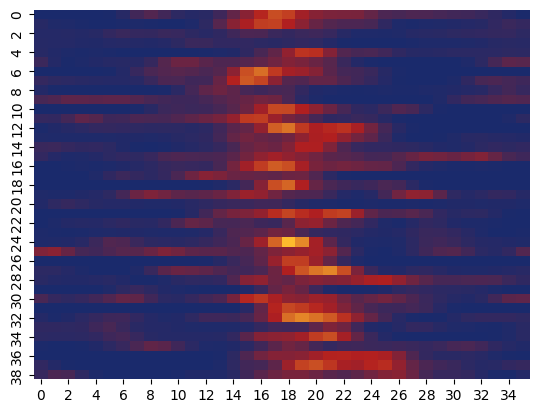

In [80]:
fig, ax =plt.subplots()

sns.heatmap(plotArray,cmap=modelCmap,cbar=False,ax=ax)

In [81]:
def label_model_mvl_on_polar_plot(ax,hdMap1,hdMap2,colors=[LOWERCOLOR,HIGHERCOLOR],y1=0.98,y2=0.88):
    _,hdMap1_meanRad,hdMap1_mvl,_,_ = head_direction_score_from_histo(hdMap1)
    _,hdMap2_meanRad,hdMap2_mvl,_,_ = head_direction_score_from_histo(hdMap2)
    
    ax.text(0.05,y1,f'MVL: {round(hdMap1_mvl,2)}',c = colors[0],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes,fontweight='bold')
    ax.text(0.05,y2,f'Dir.: {round(hdMap1_meanRad,2)}°',c = colors[0],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes,fontweight='bold')
    
    
    ax.text(0.65,y1,f'{round(hdMap2_mvl,2)}',c = colors[1],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes,fontweight='bold')
    ax.text(0.65,y2,f'{round(hdMap2_meanRad,2)}°',c = colors[1],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes,fontweight='bold')

In [82]:
def plot_model_prediction_headingDir_colorbar(ax,sesName,condition):
    testDf = getDfBySesName(sesName).copy()

    testDf['homingDir'] = np.radians(testDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    testDf['homingDir'] = centerAngles(testDf['homingDir'])
    testDf = filterForConditions(testDf).copy()
    
    
    inputLS = testDf[testDf.condition == condition].copy()
    inputLS = inputLS.sort_values(by='homingDir',ascending=True)
    
    
    modelCmap = LinearSegmentedColormap.from_list("custom_colormap", COLORSFORHEADINGLEFTRIGHT, N=256)
    
    dataInput = np.array([inputLS.homingDir.values]).T
    
    sns.heatmap(data=dataInput, cmap = modelCmap, cbar=False, xticklabels=False,yticklabels=False,ax=ax,vmax = hue_max,vmin=hue_min)

    yticks = dataInput.shape[0]


In [83]:
def plot_path_with_colors_in_grid_space(ax,df,condition = 'atLever_dark',predicted=False,trial=None,colorList = ['#0081a7','#00afb9','#fca04a','#f07167'],
                            predCL = ['#0081a7','#00afb9','#fca04a','#f07167'],xlim=(-60,60),ylim= (-60,60),noTitle=False,borderColor = '#edede9',ylabel='',xlabel='',transform=True,color_map_hue='homingDir',centerOnLever=False):

    customCmap = LinearSegmentedColormap.from_list('custom',COLORSFORHEADINGLEFTRIGHT)
    color_map_hue = 'homingDir'


    plotSlice =  df[df.condition == condition].copy()

    if transform:
        plotSlice = transform_coord(plotSlice)
    
    if trial != None:
        plotSlice = plotSlice[plotSlice.trialNo == trial]
        

    
    colorIndex= 0 
        
    if predicted:
        if centerOnLever:
            sns.scatterplot(data =plotSlice, x = 'pred_pathCenterOnLever_x',y = 'pred_pathCenterOnLever_y', s =4,alpha=1,hue = color_map_hue, palette = customCmap,edgecolor='none') #leverCenterActualpX
        else:
            sns.scatterplot(data =plotSlice, x = 'ActualCoordpx',y = 'ActualCoordpy', s =4,alpha=1,hue = color_map_hue, palette = customCmap,edgecolor='none') #leverCenterActualpX
    else:
        if centerOnLever:

            sns.scatterplot(data = plotSlice, x = 'pathCenterOnLever_x',y = 'pathCenterOnLever_y', s =4,alpha=1, hue = color_map_hue, palette = customCmap, edgecolor='none',legend=False,hue_norm=GLOBALHUENORM) #leverCenterActualX
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        else:
            sns.scatterplot(data = plotSlice, x = 'xPose',y = 'yPose', s =4,alpha=1, hue = color_map_hue, palette = customCmap, edgecolor='none',legend=False) #leverCenterActualX
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
    if noTitle:
        ax.set_title("")
    else:
        if predicted:
            ax.set_title("Pred. path")
        else:
            if centerOnLever:
                ax.set_title("Homing path\ncentered on lever")
            else:
                ax.set_title("Real path")
            
    ax.set_xlabel(ylabel)
    ax.set_ylabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    


    if predicted:
        draw_circle(ax,c=borderColor)
        draw_circle(ax,r=40,lw=1,ls='dashed',c=borderColor)
    else:
        if centerOnLever:
            pass
        else:
            draw_circle(ax,c=borderColor)
            draw_circle(ax,r=40,lw=1,ls='dashed',c=borderColor)



In [84]:
def plot_path_with_gray_colors_in_grid_space(ax,df,condition = 'atLever_dark',predicted=False,trial=None,colorList = ['#0081a7','#00afb9','#fca04a','#f07167'],
                            predCL = ['#0081a7','#00afb9','#fca04a','#f07167'],xlim=(-60,60),ylim= (-60,60),noTitle=False,borderColor = '#edede9',ylabel='',xlabel='',transform=True,color_map_hue='homingDir',centerOnLever=False):

    customCmap = LinearSegmentedColormap.from_list('custom',['#adb4bd','#adb4bd'])
    color_map_hue = 'homingDir'


    plotSlice =  df[df.condition == condition].copy()

    if transform:
        plotSlice = transform_coord(plotSlice)
    
    if trial != None:
        plotSlice = plotSlice[plotSlice.trialNo == trial]
        

    
    colorIndex= 0 
        
    if predicted:
        if centerOnLever:
            sns.scatterplot(data =plotSlice, x = 'pred_pathCenterOnLever_x',y = 'pred_pathCenterOnLever_y', s =4,alpha=1,hue = color_map_hue, palette = customCmap,edgecolor='none') #leverCenterActualpX
        else:
            sns.scatterplot(data =plotSlice, x = 'ActualCoordpx',y = 'ActualCoordpy', s =4,alpha=1,hue = color_map_hue, palette = customCmap,edgecolor='none') #leverCenterActualpX
    else:
        if centerOnLever:

            sns.scatterplot(data = plotSlice, x = 'pathCenterOnLever_x',y = 'pathCenterOnLever_y', s =4,alpha=1, hue = color_map_hue, palette = customCmap, edgecolor='none',legend=False,hue_norm=GLOBALHUENORM) #leverCenterActualX
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        else:
            sns.scatterplot(data = plotSlice, x = 'xPose',y = 'yPose', s =4,alpha=1, hue = color_map_hue, palette = customCmap, edgecolor='none',legend=False) #leverCenterActualX
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
    if noTitle:
        ax.set_title("")
    else:
        if predicted:
            ax.set_title("Pred. path")
        else:
            if centerOnLever:
                ax.set_title("Homing path\ncentered on lever")
            else:
                ax.set_title("Real path")
            
    ax.set_xlabel(ylabel)
    ax.set_ylabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if predicted:
        draw_circle(ax,c=borderColor)
        draw_circle(ax,r=40,lw=1,ls='dashed',c=borderColor)
    else:
        if centerOnLever:
            pass
        else:
            draw_circle(ax,c=borderColor)
            draw_circle(ax,r=40,lw=1,ls='dashed',c=borderColor)

In [85]:
def plot_left_right_sorted_heatmap(ax,cluid,inputDf,lightCondition='dark',fillNan = False,ylabel='Trials',convolution=False,headingError=True):
    
    plotSlice = inputDf[(inputDf.cluId == cluid)&(inputDf.lightCondition == lightCondition)].copy()


    plotSlice['homingDir'] = np.radians(plotSlice['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    plotSlice['homingDir'] = centerAngles(plotSlice['homingDir'])
    
    if headingError:
        sortSlice = plotSlice.sort_values(by='homingDir',ascending=True)
    else:
        sortSlice = plotSlice.sort_values(by='homingErrorAtPeriphery',ascending=True)
    #print(sortSlice.homingErrorAtPeriphery.values)
        
    
    heatmapSlice = np.array(sortSlice.iloc[:,-36:])
    if fillNan:
        heatmapSlice = np.apply_along_axis(interpolate_histogram,axis=1,arr= heatmapSlice)
        
    if convolution:

        shiftIndex = np.argmax(np.nanmean(heatmapSlice,axis=0))
        heatmapSlice = np.roll(heatmapSlice,18-shiftIndex,axis=1)
        
        heatmapSlice = smooth_heatmap(heatmapSlice)
        heatmapSlice = normalize_2d_array(heatmapSlice)
        
        
        
        sns.heatmap(heatmapSlice,cmap='viridis',cbar=False,ax=ax)

    else:
        shiftIndex = np.argmax(np.nanmean(heatmapSlice,axis=0))
        heatmapSlice = normalize_2d_array(heatmapSlice)
        sns.heatmap(np.roll(heatmapSlice,18-shiftIndex,axis=1),cmap='viridis',cbar=False,ax=ax)
        
    

    maxInd = get_test_trial_drift_from_slice(plotSlice,headingError=True)
    
    for i, max_index in enumerate(maxInd):
        ax.plot(max_index+0.5,i+0.5,marker='^',color='red',ms=3) #'|'
    
    ax.set_xticks(ticks=[0, 18, 36])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    #ax.set_yticks([])
    #ax.set_yticklabels([])

    yticks = heatmapSlice.shape[0]

    ax.set_yticks([0,  yticks - 1])
    ax.set_yticklabels([yticks - 1, 0])

    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Direction (rad)',fontsize=GLOBALFONTSIZE)

In [86]:
def left_right_boxplot(ax, dfMedianSplitLR, light ='dark', colors=[LOWERCOLOR],ylim=0.8,ylabel='Right-left rot.',removeX = False):
    
    var = 'value'
    def mySummary(df):        
        error = np.nanmean(df[f"{var}"])        
        return pd.DataFrame({f"{var}": [error]})
    
    processDf = dfMedianSplitLR[dfMedianSplitLR.lightCondition == light].copy()
    
    shiftDf = get_shift_dataframe(processDf)


    shiftByCell = shiftDf.groupby(['mouse','variable']).apply(mySummary).reset_index()
    

    b = sns.boxplot(data=shiftByCell,x = 'variable', y = 'value', ax=ax, palette=['white'],width=0.3,showfliers=False, **boxplot_kwargs)
    sns.stripplot(data=shiftByCell, x= "variable", y="value", dodge = True,size=8,alpha=0.5,palette=[colors[0]],**stripplot_kwargs)
    
    ax.axhline(y=0,color='r',linestyle='--',label='0 radians',lw=2)
    
    ax.set_xticklabels([])
    #ax.set_xticks([])
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Observations',fontsize=GLOBALFONTSIZE)
    
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1])
    if removeX:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel('')
    #ax.set_ylim(0,ylim)
    
    ax.set_ylim(-1,1.2)
    
    #ax.set_ylabel(ylabel)
    ax.set_title('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    number = len(shiftByCell.mouse.unique())
    
    res = scipy.stats.wilcoxon(shiftByCell['value'].values,[0]*len(shiftByCell['value']))
    
    ax.text(0.07,0.96, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    ax.text(0.07,0.85, f'P-value = {round(res[1],4)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

In [87]:
import math
import scipy
def get_shift_index(hist1,hist2):
    corrHolder = []
    for i in range(len(hist1)):
        #rolledCor = scipy.signal.correlate(hist1,np.roll(hist2,i),mode='valid')
        rolledCor, _ = scipy.stats.pearsonr(hist1,np.roll(hist2,i))
        corrHolder.append(rolledCor)
        
    shiftIndex = np.argmax(corrHolder)
    shiftDegree = shiftIndex*10
    
    radians = math.radians(shiftDegree)
    
    radians = math.remainder(radians,math.tau)
        
    return radians
    
def get_shift_dataframe(inputDf):
    cluHolder = []
    aboveBelowHolder = []
    for cluId in inputDf.cluId.unique():
        histoSlice = inputDf.loc[(inputDf.cluId == cluId)&(inputDf.medianCondition == 'aboveMedianIntervals')].copy()
        aboveIntervalHist = histoSlice.iloc[:,-36:].values.squeeze()

        histoSlice = inputDf.loc[(inputDf.cluId == cluId)&(inputDf.medianCondition == 'belowMedianIntervals')].copy()
        belowIntervalHist = histoSlice.iloc[:,-36:].values.squeeze()

        above_below_shift = get_shift_index(aboveIntervalHist,belowIntervalHist)

        cluHolder.append(cluId)
        aboveBelowHolder.append(above_below_shift)

    shiftByCell = pd.DataFrame(list(zip(cluHolder,aboveBelowHolder)),
             columns = ['cluId','above_below_shift'])

    shiftByCell = shiftByCell.melt(id_vars='cluId')

    shiftByCell['mouse'] = shiftByCell['cluId'].apply(lambda x: x.split('-')[0])

    return shiftByCell
    

In [88]:
def plotRegressionLine(ax,x,y,regColor = '#ff9e00'):
    
    realR = circcorrcoef(x,y)
    anglesCentered = centerAngles(x)
    model = LinearRegression()
    model.fit(anglesCentered[:,np.newaxis],y)
    

    # Extend the range of x-values for the line
    x_line = np.array(np.linspace(x.min() - 1, x.max() + 1, 100))

    # Generate the y-values for the line using the slope and intercept
    y_line = model.predict(x_line[:,np.newaxis])

    # Plot the regression line
    ax.plot(x_line, y_line, color=regColor,lw=2.5,linestyle='-')
    #ax.plot(x_line, y_line, color='red',lw=2.5,linestyle='-')

    
def plot_trialMatrix_correlation(ax,cluid,inputDf,lightCondition='dark',c='#12c2e9',var_y='homingErrorAtPeriphery',var_x = 'trialDrift',signLevel = 0.025,set_ylabel=True,returnStats=False): #homingErrorAtPeriphery
    
    plotSlice = inputDf[(inputDf.cluId == cluid)&(inputDf.lightCondition == lightCondition)].copy()
    plotSlice.insert(0,'leftOrRight',np.where(plotSlice.homingErrorAtPeriphery < plotSlice.homingErrorAtPeriphery.median(), 'left', 'right'))  
    
    plotSlice['homingDir'] = np.radians(plotSlice['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
    plotSlice['homingDir'] = centerAngles(plotSlice['homingDir'])
    
   
    sortSlice = plotSlice.sort_values(by=var_y,ascending=True)
        
    sortSlice.insert(0,'trialDrift',get_trial_drift_from_slice(sortSlice,convolution=GLOBALCONV))

    
    b = sns.kdeplot(data=sortSlice, x=var_x,
                    y=var_y,ax=ax,s=40,fill=True,alpha=1,color = c)
    
    sns.scatterplot(data=sortSlice, x=var_x,
                    y=var_y,ax=ax,s=40,edgecolor='black',linewidth=1,color = c)

    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    xVal = sortSlice[var_x].values
    yVal = sortSlice[var_y].values
    
    
    plotRegressionLine(ax,x = xVal, y = yVal,regColor = 'red')
    
    if set_ylabel:
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel('Homing heading',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        ax.set_ylabel('',fontsize=GLOBALFONTSIZE)
    
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    
    
    ax.set_xlabel('Trial drift',fontsize=GLOBALFONTSIZE)
    
    ax.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)
    
    realR, slope, sigN, _ = homing_angle_corr_stats(xVal,yVal,signLevel=signLevel)
    
    if sigN:
        label_x = 0.65 #0.05
        label_y1 = 0.05 #0.8
        label_y2 = 0.17 #0.92
        ax.text(label_x, label_y1, 's: ' + str(round(slope, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        ax.text(label_x, label_y2, f'r: ' + str(round(realR, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
    else:
        ax.text(0.1, 0.8, 'Not sig.', fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
        
    borders = np.pi+np.pi/6
    
    ax.set_xlim(-borders,borders)
    ax.set_ylim(-borders,borders)

    if returnStats:
        return realR, slope, sigN

In [89]:
def get_test_trial_drift_from_slice(inputDf,gaus=True,headingError=False):
    # Shift the trial matrix so that everything is aligned to the center
    shiftedArrayHolder = []
    if headingError:
        sortSlice = inputDf.sort_values(by='homingDir',ascending=True)
    else:
        sortSlice = inputDf.sort_values(by='homingErrorAtPeriphery',ascending=True)
        
    for i in range(0,inputDf.shape[0]):
        heatmapSlice = np.array(sortSlice.iloc[i,-36:])
        shiftIndex = np.argmax(heatmapSlice)
        shiftedArray = np.roll(heatmapSlice,18-shiftIndex).astype(float)
        shiftedArray = interpolate_histogram(shiftedArray)
        shiftedArrayHolder.append(shiftedArray)

    shiftedCenterArray = np.array(shiftedArrayHolder)
    shiftedMeanArray = np.nanmean(shiftedCenterArray,axis=0)
    
    corArrayHolder = []
    shiftedMeanArray = interpolate_histogram(shiftedMeanArray)

    shiftIndex = np.argmax(np.nanmean(sortSlice.iloc[:,-36:],axis=0))

    for i in range(0,sortSlice.shape[0]): 

        heatmapSlice = np.array(sortSlice.iloc[i,-36:]).astype(float)

        interHeatmap = interpolate_histogram(heatmapSlice)
        interHeatmap = np.roll(interHeatmap,18-shiftIndex) #This centers the array
        
        if gaus:
            crossCor = smooth_heatmap(interHeatmap)
        else:
            crossCor = np.correlate(interHeatmap,shiftedMeanArray,mode='same')
        corArrayHolder.append(crossCor)
        
    driftIndex = np.argmax(corArrayHolder,axis=1)
    
    return driftIndex

In [90]:
cellID = 'mn8578-23122021-0108_10'
def returnDataFrameDf(cellId,inputDf,light='dark',medianCondition = 'Inaccurate homing', var= 'hd_vector'):
    cond = (inputDf.cluId == cellId)&(inputDf.lightCondition == light)&(inputDf.medianCondition == medianCondition)
    return round(inputDf[cond][var].values[0],1)

def label_mvl_peak_on_polar_plot(ax,cellID,inputDf,colors=[LOWERCOLOR,HIGHERCOLOR],y1=0.98,y2=0.88,medianCondition1= 'Accurate homing', medianCondition2 = 'Inaccurate homing'):
    acc_mvl = returnDataFrameDf(cellID,inputDf,light='dark',medianCondition=medianCondition1, var='hd_vector')
    inacc_mvl = returnDataFrameDf(cellID,inputDf,light='dark',medianCondition=medianCondition2, var='hd_vector')
    acc_peak = returnDataFrameDf(cellID,inputDf,light='dark',medianCondition=medianCondition1, var='hd_peak_rate')
    inacc_peak = returnDataFrameDf(cellID,inputDf,light='dark',medianCondition=medianCondition2, var='hd_peak_rate')
    
    ax.text(0.05,y1,f'MVL: {acc_mvl}',c = colors[0],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes)
    ax.text(0.05,y2,f'Peak: {acc_peak}',c = colors[0],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes)
    
#     ax.text(0.65,1.16,f'MVL:{inacc_mvl}',c = colors[1],fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
#     ax.text(0.65,1.06,f'Peak:{inacc_peak}hz',c = colors[1],fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
    
    ax.text(0.6,y1,f'{inacc_mvl}',c = colors[1],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes)
    ax.text(0.6,y2,f'{inacc_peak}Hz',c = colors[1],fontsize=GLOBALFONTSIZE-2,transform=ax.transAxes)

In [91]:
def custom_stripplot_longShort(ax, inputDf, cond ='searchToLeverPath_dark',var = 'mvl',jitter=0.05, alpha=0.5,
                     ms=8, mew=1, linewidth=0.5, linestyle='--', colors=['#3f92e9','#ff5630'],ylim=1,ylabel='Mean vector length (MVL)',Circular=False,customYTicks=False,title=''):
    inputDf.replace({'short':'Short search','long':'Long search'},inplace=True)
    splitVariable = ['Short search','Long search']
    order = splitVariable
    xVal = 'splitMedianCondition'


    processDf = inputDf[inputDf.condition == cond].copy()
   
    aggregatedMVL = pd.pivot_table(data=processDf,values = var,index='sessionName',columns=xVal).reset_index().copy()

    aggMvlNumpy = aggregatedMVL.loc[:,splitVariable].values
       
       
    df = pd.DataFrame(aggMvlNumpy)

    df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
    df_x_jitter += np.arange(len(df.columns))
   
   
    #Boxplot

    b = sns.boxplot(data=processDf,x = xVal, y = var, ax=ax, palette=['white'],order = splitVariable,showfliers=False,width=0.55, **boxplot_kwargs)
   
    p = processDf[xVal].unique()
   
    pairs = [(p[0],p[1])]
    annotator = Annotator(b, pairs, data=processDf,
                          x = xVal, y = var,order=splitVariable)

    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
   
    for i, col in enumerate(df):
        if colors is not None:
            color = colors[i]
        else:
            color = 'C{}'.format(i)  # Use default Matplotlib color cycle

        ax.plot(df_x_jitter[col], df[col], 'o', alpha=alpha, zorder=1, ms=ms, mew=mew, color=color)

    ax.set_xticks(range(len(df.columns)))
    #ax.set_xticklabels(df.columns,fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-0.5, len(df.columns) - 0.5)

    for idx in df.index:
        for i in range(0, len(df.columns), 2):
            ax.plot(df_x_jitter.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    df.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    color='grey', linewidth=linewidth, linestyle=linestyle, zorder=-1)
           
   
   
    ax.set_xticklabels(splitVariable,fontsize=GLOBALFONTSIZE)
   
    ax.set_ylim(0,ylim)
    #ax.set_yticks([-np.pi/2,0,np.pi/2])
    #ax.set_yticklabels(["-$\pi$/2","0","$\pi$/2"])
   
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    
    ax.set_xticklabels(['Short\nsearch','Long\nsearch'])
    if customYTicks:
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])
        ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])
   
    number = len(processDf.sessionName.unique())
   
    res = scipy.stats.wilcoxon(processDf[processDf[xVal] == order[0]][var].values,processDf[processDf[xVal] == order[1]][var].values)
   
    
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    ax.text(0.07,0.81, f'P-value = {round(res[1],4)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

In [92]:
def plot_linePlot_beg_end(ax0,begEndLineDfAll,begColor = '#00AFB9',endColor = '#F07167',legend=True,legendX=0.27,legendY=0.75,ylim=0.1,title='',xlabel='Decoded dir. error',lw=2):
    sns.lineplot(data=begEndLineDfAll,x='bin_edges',y='Q1',color=begColor,ax=ax0)
    sns.lineplot(data=begEndLineDfAll,x='bin_edges',y='Q4',color=endColor,ax=ax0)

    ax0.set_title(title,fontsize=GLOBALFONTSIZE)

    ax0.set_ylim(0,ylim)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax0.set_ylabel('Density')
    ax0.set_xticks(ticks=[0, 18,35])
    ax0.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)

    values1= begEndLineDfAll.Q1.values
    values2= begEndLineDfAll.Q4.values

    # Perform a statistical test to compare the two datasets
    t_stat, p_value = stats.ks_2samp(values1, values2)

    # Print the results
    print(f"Kolmogorov-Smirnov Test Statistic: {t_stat}")
    print(f"P-value: {p_value}")

    # Interpret the results
    if p_value < 0.05:
        print("The two datasets are significantly different.")
    else:
        print("There is no significant difference between the two datasets.")



    #ax.axvline(x=light_median, c=colorList[0],lw=1.5)
    #ax.axvline(x=dark_median,c=colorList[1],lw=1.5)
    if legend:
        legend_labels = ['Beg.','End']
        legend_colors = [begColor,endColor]

        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]

        ax0.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))

In [93]:
def plot_curve_with_MVL(ax0,begEndLineDfAll,sName,Q = 'Q4',fixedMax=0.1,heatmapToPlot=[1,1]):
    xV = begEndLineDfAll[begEndLineDfAll.sessionName == sName].bin_edges.values
    yV = begEndLineDfAll[begEndLineDfAll.sessionName == sName][Q].values


    yVNormalize = fixedMax - (yV - yV.min()) / (fixedMax - yV.min())*len(yV) + len(heatmapToPlot)
    ax0.plot(xV,yVNormalize,color='white',lw=2)
    _,_,q_mvl,_,_ = head_direction_score_from_histo(yV)
    ax0.text(0.25,0.9,f'MVL: {round(q_mvl,2)}',fontsize=GLOBALFONTSIZE,fontweight='bold', transform=ax0.transAxes,color='white')

In [94]:
def plot_path_in_grid_space_ls(ax,df,condition = 'atLever_dark',predicted=False,trial=None,colorList = ['#0081a7','#00afb9','#fca04a','#f07167'],
                            predCL = ['#0081a7','#00afb9','#fca04a','#f07167'],xlim=(-60,60),ylim= (-60,60),noTitle=False,borderColor = '#edede9',ylabel='',xlabel='',transform=True):
    plotSlice =  df[df.condition == condition].copy()
    if transform:
        plotSlice = transform_coord(plotSlice)
    
    if trial != None:
        plotSlice = plotSlice[plotSlice.trialNo == trial]

    colorIndex= 0 
        
    if predicted:
        sns.scatterplot(data =plotSlice, x = 'ActualCoordpx',y = 'ActualCoordpy', s =4,alpha=1,color = predCL[colorIndex],edgecolor='none') #leverCenterActualpX
    else:
        sns.scatterplot(data = plotSlice, x = 'ActualCoordx',y = 'ActualCoordy', s =4,alpha=1,color = colorList[colorIndex],edgecolor='none') #leverCenterActualX
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    if noTitle:
        ax.set_title("")
    else:
        if predicted:
            ax.set_title("Pred. path")
        else:
            ax.set_title("Real path")
            
    ax.set_xlabel(ylabel)
    ax.set_ylabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    if predicted:
        draw_circle(ax,edge_color=borderColor)
        draw_circle(ax,r=40,lw=1,ls='dashed',edge_color=borderColor)
    else:
        draw_circle(ax,edge_color=borderColor)
        draw_circle(ax,r=40,lw=1,ls='dashed',edge_color=borderColor)

In [95]:
from matplotlib.colors import LinearSegmentedColormap


def plot_distribution_by_condition_sort_condition(ax, input_df, condition='searchToLeverPath_dark', sort_condition='searchLength', z_score_row=False, smooth=False, no_xticks=False, convolution=False, session='', ylabel='Trials', set_ticks=True,set_yticks=True):
    # Filter input dataframe by condition
    plot_slice = input_df[input_df.condition == condition].copy()
    plot_slice = plot_slice.sample(frac=1,random_state=28).copy()
    
    # Get the values for plotting
    plot_array = plot_slice.iloc[:, -37:-1].values
    
    # Calculate the sum of histograms
    histos = np.nansum(plot_array, axis=0)

    # Perform head direction score calculation
    _, _, output_mvl, _, _ = head_direction_score_from_histo(histos)

    # Perform z-score transformation
    if z_score_row:
        row_mean = np.mean(plot_array, axis=1)
        row_std = np.std(plot_array, axis=1)
        plot_array = (plot_array - row_mean[:, np.newaxis]) / row_std[:, np.newaxis]

    # Apply rolling average smoothing
    if smooth:
        num_columns_after_smoothing = 18
        step = plot_array.shape[1] // num_columns_after_smoothing
        plot_array = np.apply_along_axis(lambda x: np.mean(x.reshape(-1, step), axis=1), axis=1, arr=plot_array)

    # Get histos per trial from a slice
    df_of_slice = dfOf[dfOf.session == session].copy()
    histos_from_of = get_histos_per_trial(df_of_slice)

    # Get trial drift from slice and localize shifted mean array
    input_ls = input_df[input_df.condition == condition].copy()
    plot_array, max_ind = get_trial_drift_from_slice_ls(input_ls, getMatrix=True, shiftedMeanArray=histos_from_of, convolution=convolution)
    plot_array = normalize_2d_array(plot_array)

    # Plot heatmap
    sns.heatmap(plot_array, cmap=cmapShortLong, ax=ax, cbar=False)

    # Plot trial drift
    if set_ticks:
        for i, max_index in enumerate(max_ind):
            pass

    # Set labels and ticks
    ax.set_ylabel(ylabel)

    yticks = plot_array.shape[0]

    if set_yticks:
        ax.set_yticks([0,  yticks - 1])
        ax.set_yticklabels([yticks - 1, 0], rotation=0)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    ax.set_xticks([0, 18, 36])
    ax.set_xticklabels(['-$\pi$', '0', '$\pi$'])

    # Set xticks based on the condition
    if no_xticks:
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_xticklabels([])

In [ ]:
def plot_long_short_search_examples(gs0,startPoint = 0):
    ###First Row### 
    s1 = 'jp486-18032023-0108'
    t=127

    cond = 'searchToLeverPath_dark'
    
    sessionSliceT = prepareTrialDfBinned(s1,t)
    
    ax0 = fig.add_subplot(gs0[startPoint,1])
    
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q1'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#00AFB9'],predCL=['#00AFB9'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q2'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q3'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q4'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#F07167'],predCL=['#F07167'],transform=False)
    
    ax0 = fig.add_subplot(gs0[startPoint,2])
    
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q1'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#00AFB9'],predCL=['#00AFB9'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q2'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q3'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q4'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#F07167'],predCL=['#F07167'],transform=False)


    sName = s1
    heatmapToPlotQ1 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q1'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ1['emptyHolder'] = np.nan
    
    heatmapToPlotQ4 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q4'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ4['emptyHolder'] = np.nan

    ax0 = fig.add_subplot(gs0[startPoint,3])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ1,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName)
    ax0.set_title('Beginning',color = BEGCOLOR)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q1',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ1)
    
    ax0 = fig.add_subplot(gs0[startPoint,4])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ4,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName,ylabel='')
    ax0.set_title('End',color = ENDCOLOR)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q4',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ4)
    

    ###Second Row###
    s1 = 'jp3269-28112022-0108'
    t=32 

    cond = 'searchToLeverPath_dark'
    
    sessionSliceT = prepareTrialDfBinned(s1,t)

    ax0 = fig.add_subplot(gs0[startPoint+1,1])
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q1'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#00AFB9'],predCL=['#00AFB9'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q2'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q3'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q4'],condition='searchToLeverPath_dark',predicted=False,trial=t,colorList=['#F07167'],predCL=['#F07167'],transform=False,noTitle=True)
    
    
    ax0 = fig.add_subplot(gs0[startPoint+1,2])
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q1'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#00AFB9'],predCL=['#00AFB9'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q2'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q3'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#8E9AAF'],predCL=['#8E9AAF'],transform=False,noTitle=True)
    plot_path_in_grid_space_ls(ax0,sessionSliceT[sessionSliceT.withinTrialSplit == 'Q4'],condition='searchToLeverPath_dark',predicted=True,trial=t,colorList=['#F07167'],predCL=['#F07167'],transform=False,noTitle=True)

    sName = s1
    heatmapToPlotQ1 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q1'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ1['emptyHolder'] = np.nan
    
    heatmapToPlotQ4 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q4'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ4['emptyHolder'] = np.nan

    ax0 = fig.add_subplot(gs0[startPoint+1,3])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ1,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName)
    ax0.set_xlabel('Pred. dir. error',fontsize=GLOBALFONTSIZE)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q1',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ1)

    
    ax0 = fig.add_subplot(gs0[startPoint+1,4])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ4,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName,ylabel='')
    ax0.set_xlabel('Pred. dir. error',fontsize=GLOBALFONTSIZE)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q4',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ4)

    
    # Add the stats together
    ax0 = fig.add_subplot(gs0[0,5])
    plot_linePlot_beg_end(ax0,begEndLineDfAll)

    ax0 = fig.add_subplot(gs0[0,6])
    custom_stripplot_longShort(ax0,mvlDfCond,cond ='atLever_dark',var = 'mvl',ylabel='MVL',title='At lever',ylim=1.1)
    
    ax0 = fig.add_subplot(gs0[1,5])
    modelLengthDf = get_model_time_bin(full_all_sessions.copy())   
    modelLengthDf['timeBinName'] = modelLengthDf['timeBinName'].astype(float)
    plot_model_error_by_search_length(ax0,modelLengthDf,title='Search')

    ax0 = fig.add_subplot(gs0[1,6])
    custom_stripplot_longShort(ax0,driftStatsLongShortM,cond ='atLever_dark',var = 'meanDrift',ylim=2,ylabel='Dir. drift',customYTicks=True,title='')
    

In [97]:
arenaBorderColor= '#BAD7E9'
def draw_circle(ax, r=44, edge_color=arenaBorderColor, center=(0, 0), lw=2, ls='solid'):
    circle = plt.Circle(center, r, edgecolor=edge_color, facecolor='none', lw=lw, linestyle=ls, alpha=1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)

In [98]:
def plot_model_error_by_search_length(ax,inputDf,title='',ylabel="Abs. decoded\ndir. error",xlabel="Search duration (sec)"):

    sns.stripplot(data=inputDf,x="timeBinName",y="absMvtDirError",edgecolor="black",palette=['#0b8793'],s=7,ax=ax,**stripplot_kwargs)
    b = sns.boxplot(data=inputDf,x="timeBinName",y="absMvtDirError", showfliers = False,palette=['#FFFFFF'],ax=ax,**boxplot_kwargs)
    

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax.set_title(f'{title}',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)


    var_x = 'timeBinName'
    var_y = 'absMvtDirError'

    
    binList = inputDf[var_x].unique()
    f1 = inputDf[inputDf[var_x] == binList[0]].absMvtDirError.values
    f2 = inputDf[inputDf[var_x] == binList[1]].absMvtDirError.values
    f3 = inputDf[inputDf[var_x] == binList[2]].absMvtDirError.values
    f4 = inputDf[inputDf[var_x] == binList[3]].absMvtDirError.values
    
    stats, p = scipy.stats.friedmanchisquare(f1,f2,f3,f4)

    print(f'friedmanchisquare stats{stats} P ={p}')
    
    roundedP = round(p, 4)
    pDisplay = f'p = {roundedP}'
    if roundedP < 0.0001:
        pDisplay = f'p < 0.0001'
        
    number = len(inputDf.session.unique())
    
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

    ax.text(0.42, 0.05, 'stats = ' + str(round(stats, 3)), fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
    ax.text(0.42, 0.15, f'{pDisplay}', fontsize=GLOBALFONTSIZE,transform = ax.transAxes)

In [99]:
def plot_left_right_paths(ax,input_cell_id,title='',ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR],headingAngle=True):
    cell_id = input_cell_id
    mouseName = cell_id.split('-')[0]
    sessionName = cell_id.split('_')[0]
    tempRes = res[(res.sessionName == sessionName)&(res.light == 'dark')].reset_index().copy()
    tempRes = tempRes.dropna(subset = 'homingErrorAtPeripheryLever') 

    instantaneousVariablesTemp = pd.read_csv(f'/adata/electro/{mouseName}/{sessionName}/navPathInstan.csv')
    instantaneousVariablesTemp['condition'] = instantaneousVariablesTemp.name.apply(lambda x: x.split('_')[2])
    
    fn = f'/adata/electro/{mouseName}/{sessionName}/navPathSummary.csv'
    navPathSummary = pd.read_csv(fn)

    mergedDf = get_merge_dataframe(navPathSummary, tempRes)

    if headingAngle:
        mergedDf['homingDir'] = np.radians(mergedDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
        mergedDf['homingDir'] = centerAngles(mergedDf['homingDir'])

        homingPeriMedianSlice = mergedDf.homingDir.median()
        mergedDf['belowMedian'] = np.where(mergedDf['homingDir']<homingPeriMedianSlice, True, False)

    
    
    else:
        homingPeriMedianSlice = mergedDf.homingErrorAtPeripheryLever.median()
        mergedDf['belowMedian'] = np.where(mergedDf['homingErrorAtPeripheryLever']<homingPeriMedianSlice, True, False)

    correctList = mergedDf[mergedDf.belowMedian].trialNo_x.unique()
    incorrectList = mergedDf[~mergedDf.belowMedian].trialNo_x.unique()

    inCorrect_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(incorrectList))&(instantaneousVariablesTemp.condition == 'homingFromLeavingLeverToPeriphery')]
    Correct_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(correctList))&(instantaneousVariablesTemp.condition == 'homingFromLeavingLeverToPeriphery')]
    
    
    lw=2
    
    for t in inCorrect_instanSlice.trialNo.unique():
        plotDf = inCorrect_instanSlice[inCorrect_instanSlice.trialNo ==t]
        ax.plot(plotDf['x'],plotDf['y'],c=colors[1],alpha=0.8,lw=lw)
    
    for t in Correct_instanSlice.trialNo.unique():
        plotDf = Correct_instanSlice[Correct_instanSlice.trialNo ==t]
        ax.plot(plotDf['x'],plotDf['y'],c=colors[0],alpha=0.8,lw=lw)
        
    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')  
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'{title}')
    ax.set_ylabel(ylabel)
    
def get_leftRight(gl_cell,inputHist,intervalType = 'all'):
    clu = gl_cell
    lightCondition = 'dark'


    belowOrAbove = 'belowMedianIntervals'
    belowHist = inputHist[clu][lightCondition][intervalType][belowOrAbove]['Hist']

    belowOrAbove = 'aboveMedianIntervals'
    aboveHist = inputHist[clu][lightCondition][intervalType][belowOrAbove]['Hist']
    
    return belowHist,aboveHist

In [100]:
def plot_left_right_center_on_lever_paths(ax,input_cell_id,title='',ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR],headingAngle=True):
    cell_id = input_cell_id
    mouseName = cell_id.split('-')[0]
    sessionName = cell_id.split('_')[0]
    tempRes = res[(res.sessionName == sessionName)&(res.light == 'dark')].reset_index().copy()
    tempRes = tempRes.dropna(subset = 'homingErrorAtPeripheryLever') 

    dfSlice = full_all_sessions[(full_all_sessions.session == sessionName)&(full_all_sessions.light == 'dark')].copy()
    dfSlice['conditionNoLight'] = dfSlice.condition.apply(lambda x: x.split('_')[0])


    instantaneousVariablesTemp = pd.read_csv(f'/adata/electro/{mouseName}/{sessionName}/navPathInstan.csv')
    instantaneousVariablesTemp['condition'] = instantaneousVariablesTemp.name.apply(lambda x: x.split('_')[2])
    
    fn = f'/adata/electro/{mouseName}/{sessionName}/navPathSummary.csv'
    navPathSummary = pd.read_csv(fn)

    mergedDf = get_merge_dataframe(navPathSummary, tempRes)

    if headingAngle:
        mergedDf['homingDir'] = np.radians(mergedDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
        mergedDf['homingDir'] = centerAngles(mergedDf['homingDir'])

        homingPeriMedianSlice = mergedDf.homingDir.median()
        mergedDf['belowMedian'] = np.where(mergedDf['homingDir']<homingPeriMedianSlice, True, False)

    
    
    else:
        homingPeriMedianSlice = mergedDf.homingErrorAtPeripheryLever.median()
        mergedDf['belowMedian'] = np.where(mergedDf['homingErrorAtPeripheryLever']<homingPeriMedianSlice, True, False)

    correctList = mergedDf[mergedDf.belowMedian].trialNo_x.unique()
    incorrectList = mergedDf[~mergedDf.belowMedian].trialNo_x.unique()

    inCorrect_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(incorrectList))&(instantaneousVariablesTemp.condition == 'homingFromLeavingLeverToPeriphery')]
    Correct_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(correctList))&(instantaneousVariablesTemp.condition == 'homingFromLeavingLeverToPeriphery')]
    
    
    
    lw=2
    
    for t in inCorrect_instanSlice.trialNo.unique():
        plotDf = inCorrect_instanSlice[inCorrect_instanSlice.trialNo ==t].copy()
        leverX = dfSlice[dfSlice.trialNo == t].leverX.values[0]
        leverY = dfSlice[dfSlice.trialNo == t].leverY.values[0]
        plotDf['x'] = plotDf['x'] - leverX
        plotDf['y'] = plotDf['y'] - leverY

        ax.plot(plotDf['x'],plotDf['y'],c=colors[1],alpha=0.8,lw=lw)
    
    for t in Correct_instanSlice.trialNo.unique():
        plotDf = Correct_instanSlice[Correct_instanSlice.trialNo ==t].copy()
        leverX = dfSlice[dfSlice.trialNo == t].leverX.values[0]
        leverY = dfSlice[dfSlice.trialNo == t].leverY.values[0]
        plotDf['x'] = plotDf['x'] - leverX
        plotDf['y'] = plotDf['y'] - leverY
        
        ax.plot(plotDf['x'],plotDf['y'],c=colors[0],alpha=0.8,lw=lw)
        
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'{title}')
    ax.set_ylabel(ylabel)

In [101]:
#Use a plotting function

def plot_combined_model_figure(gs,fig,startCol = 2):
    
    bdColor = '#edede9'

    #Search Example
    ax0 = fig.add_subplot(gs[0,startCol]) 

    sName = 'jp452-24112022-0109'
    sessionSlice = getSessionSlice(sesName = sName)

    tNum = 106
    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True)
    
    
    ax0.set_title('Session A')
    
    
    ax0 = fig.add_subplot(gs[1,startCol],projection='polar') 
    firstHalf, secondHalf = getModelHistosByMedian(sName,condition= 'searchToLeverPath_dark')
    
    plotHdMapTogether_model(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],title="",max_num=16,setMaxNum=True)
    ax0.spines['polar'].set_color('none')
    label_model_mvl_on_polar_plot(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],y1=0.88,y2=0.78)
    ax0.set_title('Search',fontsize=GLOBALFONTSIZE)
    
    
    
    gs0_heatmapSlice1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[2,startCol],width_ratios=[0.1,0.1,1],wspace=0)
    
    ax0 = fig.add_subplot(gs0_heatmapSlice1[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'searchToLeverPath_dark')
    ax0.set_ylabel('Trials')
    ax0 = fig.add_subplot(gs0_heatmapSlice1[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'searchToLeverPath_dark',set_ticks=True,xlabel='Pred. dir. error',ylabel='')
    
    
    
    ax0 = fig.add_subplot(gs[3,startCol])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_scatterplot(ax0,c_statsDf,ylabel='Homing heading',xlabel='Pred. dir. error',var_x = 'searchRad',var_y='homingDir',c='#cfbaf0')

    #At Lever Example
    ax0 = fig.add_subplot(gs[0,startCol+1]) 
    sName = 'jp451-28102022-0108'
    sessionSlice = getSessionSlice(sesName = sName)
    tNum = 32
    
    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True)
    
    ax0.set_title('Session B')

    ax0 = fig.add_subplot(gs[1,startCol+1],projection='polar') 
    firstHalf, secondHalf = getModelHistosByMedian(sName,condition= 'atLever_dark')
    plotHdMapTogether_model(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],title="",max_num=20,setMaxNum=True)
    ax0.spines['polar'].set_color('none')
    label_model_mvl_on_polar_plot(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],y1=0.88,y2=0.78)
    ax0.set_title('At lever',fontsize=GLOBALFONTSIZE)
    
    gs0_heatmapSlice2 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[2,startCol+1],width_ratios=[0.1,0.1,1],wspace=0)
 
    ax0 = fig.add_subplot(gs0_heatmapSlice2[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'atLever_dark')

    ax0 = fig.add_subplot(gs0_heatmapSlice2[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'atLever_dark',set_ticks=True,ylabel='',xlabel='Pred. dir. error')
    


    ax0 = fig.add_subplot(gs[3,startCol+1])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_scatterplot(ax0,c_statsDf,ylabel='Homing heading',xlabel='Pred. dir. error',var_x = 'atLeverRad',var_y='homingDir', set_ylabel= False,c='#cfbaf0')


    #Homing example
    ax0 = fig.add_subplot(gs[0,startCol+2]) 
    sName = 'jp3269-28112022-0108'
    sessionSlice = getSessionSlice(sName)
    tNum = 98
    
    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True)
    
    ax0.set_title('Session C')

    ax0 = fig.add_subplot(gs[1,startCol+2],projection='polar') 
    firstHalf, secondHalf = getModelHistosByMedian(sName,condition= 'homingFromLeavingLeverToPeriphery_dark')
    plotHdMapTogether_model(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],title="",max_num=20,setMaxNum=True)
    ax0.spines['polar'].set_color('none')
    label_model_mvl_on_polar_plot(ax0,firstHalf,secondHalf,colors= [COLORSFORHEADINGLEFTRIGHT[0],COLORSFORHEADINGLEFTRIGHT[1]],y1=0.88,y2=0.78)
    ax0.set_title('Homing',fontsize=GLOBALFONTSIZE)
    
    
    gs0_heatmapSlice3 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[2,startCol+2],width_ratios=[0.1,0.1,1],wspace=0)
    
    ax0 = fig.add_subplot(gs0_heatmapSlice3[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'homingFromLeavingLeverToPeriphery_dark')
    ax0 = fig.add_subplot(gs0_heatmapSlice3[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'homingFromLeavingLeverToPeriphery_dark',set_ticks=True,ylabel='',xlabel='Pred. dir. error')
    
    
    
    ax0 = fig.add_subplot(gs[3,startCol+2])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_scatterplot(ax0,c_statsDf,ylabel='Homing\nheading',xlabel='Pred. dir. error',var_x = 'homingRad',var_y='homingDir', set_ylabel= False,c='#cfbaf0')

    #Plot the distribution plot on the fourth column
    ax0 = fig.add_subplot(gs[1,startCol+3])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'searchRad'],xValue='realR',xLabel = '',ylabel='Sessions',legend=True,removeX=True,legendToLower=False,ylim=10,plotP=True)
    ax0.set_title('Search')

    ax0 = fig.add_subplot(gs[2,startCol+3])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'atLeverRad'],xValue='realR',xLabel = '',ylabel='Sessions',legend=False,removeX=True,removeY=False,plotP=True)
    ax0.set_title('At lever')

    ax0 = fig.add_subplot(gs[3,startCol+3])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'homingRad'],xValue='realR',xLabel = 'Pred. rot.-homing\nheading corr.',ylabel='Sessions',legend=False,removeY=False,ylim=8,plotP=True)
    ax0.set_title('Homing')

# Dataframes for plotting

In [102]:
def getSplitQuadrants(splitWithinLongTrial,cond,conditionFilter='searchToLeverPath_dark'):
    qDf = splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == cond].copy()

    dfPerTrial = getCombinedDfTrialSplit(sesName,qDf)
    dfPerTrial['emptyHolder'] = None

    outHistos = getAverageHistos(dfPerTrial,conditionFilter,sesName)

    outHistos = getSLhistosForPlotting(outHistos)

    return outHistos

In [103]:
def getCombinedDfTrialSplit(sessionName,inputDf):
    sessionSlice = inputDf[inputDf.session == sessionName].reset_index()
    combinedDf = get_combinedDf(sessionSlice.copy(),res=res,sesName = sessionName)
    combinedDf.insert(0,'sumOfHistos',np.nansum(combinedDf.iloc[:,-36:].values,axis=1))
    return combinedDf

In [104]:
def getAverageHistos(inputDf,cond,s1):

    dfOfSlice = dfOf[dfOf.session == s1].copy()
    histosFromOf = get_histos_per_trial(dfOfSlice)
    inputLS = inputDf[inputDf.condition == cond].copy()
    plotArray, _ = get_trial_drift_from_slice_ls(inputLS,getMatrix=True,shiftedMeanArray=histosFromOf,convolution=GLOBALCONV)

    plotArray = normalize_2d_array(plotArray)
    plotArray = np.nansum(plotArray,axis=0)

    return plotArray

In [105]:
def getSLhistosForPlotting(inputValues):
   
    values = inputValues

    # Calculate the total sum of values.
    total_sum = np.sum(values)

    # Normalize the values so that the area under the curve is 1.
    normalized_values = values / total_sum

    return normalized_values

In [106]:
dfHolder = []
for sessionName in tqdm(useAble):
    sessionDf = getOriginalDataframeWithTrialSplit(sessionName)
    dfHolder.append(sessionDf)
splitWithinLongTrial = pd.concat(dfHolder).reset_index(drop=True)

 25%|██▌       | 6/24 [00:34<01:39,  5.54s/it]

100%|██████████| 24/24 [02:21<00:00,  5.89s/it]


In [107]:
conditionFilter = 'searchToLeverPath_dark'

dfHolder = []
for sesName in tqdm(useAble):
    q1_histos = getSplitQuadrants(splitWithinLongTrial,cond='Q1',conditionFilter=conditionFilter)
    q2_histos = getSplitQuadrants(splitWithinLongTrial,cond='Q2',conditionFilter=conditionFilter)
    q3_histos = getSplitQuadrants(splitWithinLongTrial,cond='Q3',conditionFilter=conditionFilter)
    q4_histos = getSplitQuadrants(splitWithinLongTrial,cond='Q4',conditionFilter=conditionFilter)
    
    bin_edges = np.linspace(0, 35, num=36)

    
    begEndDf = pd.DataFrame(np.array([bin_edges,q1_histos,q2_histos,q3_histos,q4_histos]).T,columns=['bin_edges','Q1','Q2','Q3','Q4'])

    begEndDf['sessionName'] = sesName
    dfHolder.append(begEndDf)


begEndLineDfAll = pd.concat(dfHolder)

 62%|██████▎   | 15/24 [00:12<00:07,  1.15it/s]

100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


In [108]:
begEndLineDfAll

,bin_edges,Q1,Q2,Q3,Q4,sessionName
0,0.0,0.006363,0.020381,0.009591,0.002959,jp486-19032023-0108
1,1.0,0.007994,0.025537,0.008927,0.003304,jp486-19032023-0108
2,2.0,0.011252,0.024372,0.012824,0.006389,jp486-19032023-0108
3,3.0,0.018571,0.020515,0.017019,0.012471,jp486-19032023-0108
4,4.0,0.022470,0.017509,0.017220,0.018782,jp486-19032023-0108
...,...,...,...,...,...,...
31,31.0,0.015064,0.006065,0.007770,0.012613,jp1686-26042022-0108
32,32.0,0.009783,0.003936,0.007259,0.008615,jp1686-26042022-0108
33,33.0,0.004498,0.002814,0.007454,0.005720,jp1686-26042022-0108
34,34.0,0.001881,0.001730,0.007240,0.003600,jp1686-26042022-0108


In [109]:
condList = ['searchToLeverPath_dark', 'atLever_dark']

def getStatsMvlSearchLongShort():
    sesHolder = []
    shortHolder = []
    longHolder = []
    condHolder = []

    for sesName in tqdm(useAble):
        testDf = splitShortLong(getDfBySesName(sesName))

        for cond in condList:
            shortDf = testDf[testDf.splitMedianCondition == 'short']
            longDf = testDf[testDf.splitMedianCondition == 'long']

            shortHistos = np.nansum(shortDf[shortDf.condition==cond].iloc[:,-37:-1], axis=0)
            longHistos = np.nansum(longDf[longDf.condition==cond].iloc[:,-37:-1], axis=0)

            _, _, mvlShort, _, _ = head_direction_score_from_histo(shortHistos)
            _, _, mvlLong, _, _ = head_direction_score_from_histo(longHistos)

            sesHolder.append(sesName)
            shortHolder.append(mvlShort)
            longHolder.append(mvlLong)
            condHolder.append(cond)

    mvlDf = pd.DataFrame({'sessionName':sesHolder, 'short':shortHolder, 'long':longHolder, 'condition':condHolder})
    mvlDfCond = mvlDf.melt(id_vars=['sessionName', 'condition'], value_vars=['short', 'long'], var_name='splitMedianCondition', value_name='mvl')
    return mvlDfCond

In [110]:
mvlDfCond = getStatsMvlSearchLongShort()

100%|██████████| 24/24 [01:54<00:00,  4.76s/it]


In [111]:
driftStatsLongShortM = extract_long_short_drift_stats()

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [01:57<00:00,  4.90s/it]


In [112]:
full_all_sessions.columns

Index(['mouse', 'session', 'condition', 'trial', 'trialNo', 'xPose', 'yPose',
       'hdPose', 'x', 'y', 'px', 'py', 'withinPathTime', 'recTime', 'speed',
       'distance', 'v0_cos', 'v0_sin', 'v1_cos', 'v1_sin', 'lv0_cos',
       'lv0_sin', 'lv1_cos', 'lv1_sin', 'mvtDirError', 'absMvtDirError',
       'shortCondition', 'light', 'path', 'v0_cos_smooth', 'v0_sin_smooth',
       'v1_cos_smooth', 'v1_sin_smooth', 'lv0_cos_smooth', 'lv0_sin_smooth',
       'lv1_cos_smooth', 'lv1_sin_smooth', 'pSpeed', 'journey', 'timesAtLever',
       'leverX', 'leverY', 'leverDistance', 'leverCenterX', 'leverCenterY',
       'bridgeCenterX', 'bridgeCenterY', 'leverAngle', 'arenaAngle',
       'bridgeAngle', 'v0', 'v1', 'v0LeverPred', 'v1LeverPred',
       'vectorToLever_v0', 'vectorToLever_v1', 'cond_noLight'],
      dtype='object')

# Make final plot

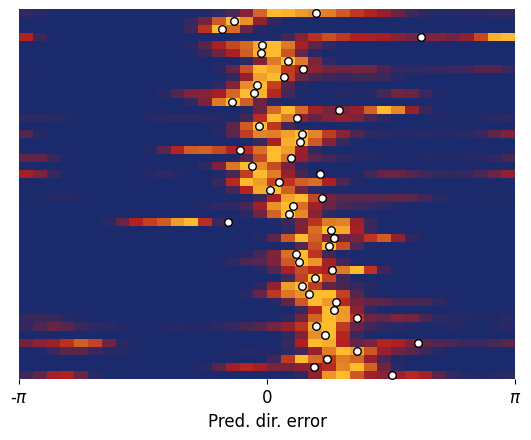

In [113]:
#Homing example
fig, ax0 = plt.subplots()
sName = 'jp3269-28112022-0108'

plot_model_prediction_heatmap(ax0,sName,'homingFromLeavingLeverToPeriphery_dark',set_ticks=True,ylabel='',xlabel='Pred. dir. error')

In [114]:
# This is already a convoluted heatmap, as the matrix returned by the function get_trial_drift_from_slice_ls returns convoluted heatmap
testDf = getDfBySesName(sName).copy()

testDf['homingDir'] = np.radians(testDf['medianMVDeviationRoomReference']).apply(lambda x: math.remainder(x,math.tau))
testDf['homingDir'] = centerAngles(testDf['homingDir'])
testDf = filterForConditions(testDf).copy()

In [115]:
testDf.condition.unique()

array(['all_dark', 'searchToLeverPath_dark',
       'homingFromLeavingLever_dark',
       'homingFromLeavingLeverToPeriphery_dark',
       'searchToLeverPathWithBridge_dark',
       'homingFromLeavingLeverWithBridge_dark', 'atLever_dark'],
      dtype=object)

In [116]:
dfOfSlice = dfOf[dfOf.session == sesName].copy()
histosFromOf = get_histos_per_trial(dfOfSlice)

inputLS = testDf[testDf.condition == 'homingFromLeavingLeverToPeriphery_dark'].copy()
inputLS = inputLS.sort_values(by='homingDir',ascending=True)

plotArray, maxInd = get_trial_drift_from_slice_ls(inputLS,getMatrix=True,shiftedMeanArray=histosFromOf,sortCondition='homingDir',convolution=GLOBALCONV)


plotArray = normalize_2d_array(plotArray)

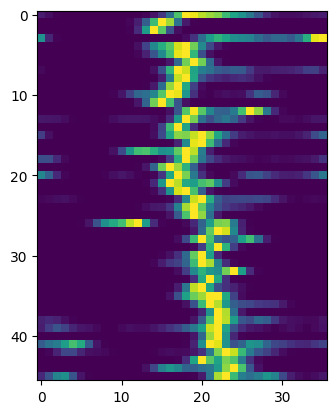

In [117]:
plt.imshow(plotArray)

In [118]:
c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())

Original Shape for session  jp3269-28112022-0108  is  46
Shape for session  jp3269-28112022-0108  is  (46, 37)


# Plot correlation

stats, p 19.0, 3.6597251892089844e-05


Text(0.5, 1.0, 'Search')

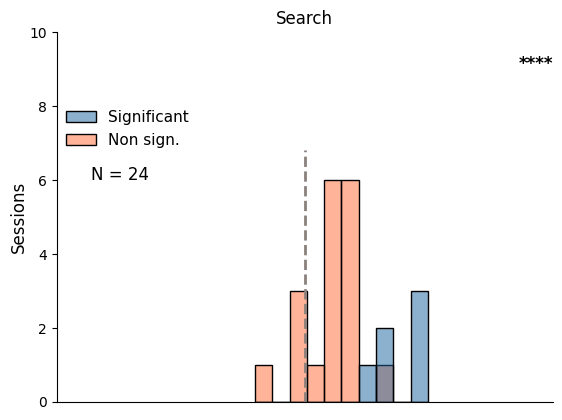

In [119]:
fig, ax0 = plt.subplots()
plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'searchRad'],xValue='realR',xLabel = '',ylabel='Sessions',legend=True,removeX=True,legendToLower=False,ylim=10,plotP=True)
ax0.set_title('Search')

stats, p 0.0, 1.1920928955078125e-07


Text(0.5, 1.0, 'At lever')

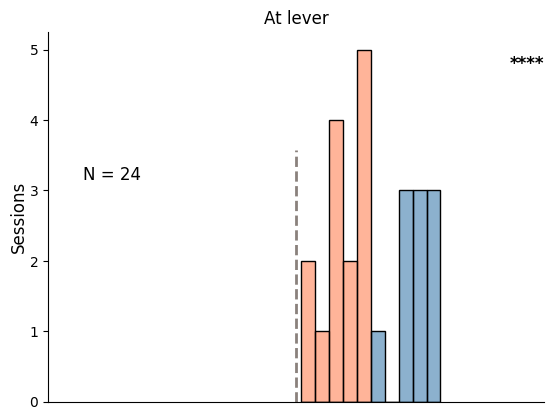

In [120]:
fig, ax0 = plt.subplots()
plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'atLeverRad'],xValue='realR',xLabel = '',ylabel='Sessions',legend=False,removeX=True,removeY=False,plotP=True)
ax0.set_title('At lever')

stats, p 20.0, 4.4226646423339844e-05


Text(0.5, 1.0, 'Homing')

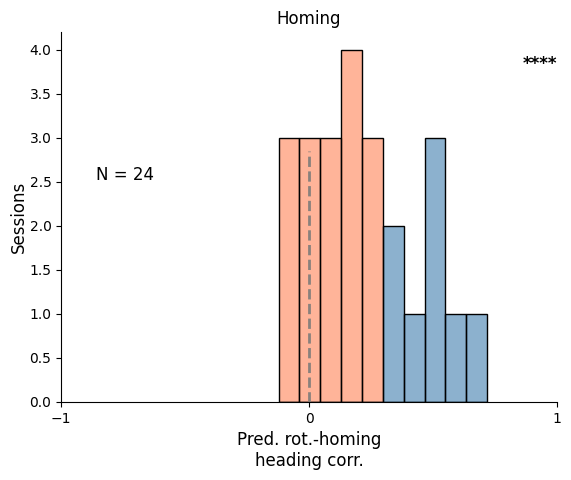

In [121]:
fig, ax0 = plt.subplots()
plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'homingRad'],xValue='realR',xLabel = 'Pred. rot.-homing\nheading corr.',ylabel='Sessions',legend=False,removeY=False,ylim=8,plotP=True)
ax0.set_title('Homing')

In [122]:
sName = 'jp451-28102022-0108'
c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())

Original Shape for session  jp451-28102022-0108  is  39
Shape for session  jp451-28102022-0108  is  (39, 37)


In [123]:
c_statsDf

,trialNo,search,searchRad,homing,atLeverRad,homingToSearch,homingRad,sessionName,light,name,...,startPositionHoming_y,homingAngleAtPeriphery,homingErrorAtPeriphery,homingErrorAtPeripheryLever,homingErrorAtPeripheryLeverAbsolute,leverX,leverY,subject,date,homingDir
0,16,2.868235,-0.481182,-2.009278,-0.170333,-2.282636,-1.245295,jp451-28102022-0108,dark,jp451-28102022-0108_16,...,-12.051145,-2.051696,-0.548365,-0.343102,0.343102,-26.341157,2.696210,jp451,2022-10-28 01:08:00,0.093782
1,18,2.327561,-0.193492,-2.937689,0.569967,2.531465,0.398097,jp451-28102022-0108,dark,jp451-28102022-0108_18,...,-15.505782,-2.044312,-0.540981,-0.368682,0.368682,-26.550886,-5.307553,jp451,2022-10-28 01:08:00,-0.089559
2,24,2.493884,0.089272,2.863510,0.745203,2.215801,1.068769,jp451-28102022-0108,dark,jp451-28102022-0108_24,...,11.692874,-0.905367,0.597964,0.357602,0.357602,-7.923025,24.672373,jp451,2022-10-28 01:08:00,0.480648
3,28,-2.502879,-0.305292,1.670895,-0.825446,2.309609,0.458665,jp451-28102022-0108,dark,jp451-28102022-0108_28,...,32.282724,-1.342278,0.161054,0.090987,0.090987,6.449948,24.157284,jp451,2022-10-28 01:08:00,0.014034
4,30,-2.957091,0.081420,-0.333894,-0.000289,-0.149393,-2.577944,jp451-28102022-0108,dark,jp451-28102022-0108_30,...,-9.370913,-1.247053,0.256278,0.213933,0.213933,1.188422,7.091144,jp451,2022-10-28 01:08:00,0.238826
5,32,2.801925,-0.394170,0.905335,-0.077462,0.565667,2.216789,jp451-28102022-0108,dark,jp451-28102022-0108_32,...,-17.543064,-1.828300,-0.324969,-0.372514,0.372514,4.285711,-5.038982,jp451,2022-10-28 01:08:00,-0.411283
6,34,-1.509802,1.024254,-0.474516,-0.593355,1.157275,3.044823,jp451-28102022-0108,dark,jp451-28102022-0108_34,...,10.521646,0.879016,2.382348,2.242187,2.242187,17.328636,25.596065,jp451,2022-10-28 01:08:00,-0.303695
7,38,-1.767909,0.962717,-2.604874,-0.445549,-1.231191,-0.700508,jp451-28102022-0108,dark,jp451-28102022-0108_38,...,-5.622374,0.190200,1.693531,2.119426,2.119426,30.131720,7.013419,jp451,2022-10-28 01:08:00,-0.278959
8,40,-2.022985,1.270614,1.838746,0.115171,2.957354,1.499874,jp451-28102022-0108,dark,jp451-28102022-0108_40,...,14.653565,1.746851,-3.033003,3.079885,3.079885,-6.235776,30.684219,jp451,2022-10-28 01:08:00,-0.097690
9,50,-2.391822,0.621882,1.629568,-0.107367,2.379339,1.387834,jp451-28102022-0108,dark,jp451-28102022-0108_50,...,-0.298262,-0.962741,0.540590,0.341392,0.341392,18.918484,14.776521,jp451,2022-10-28 01:08:00,0.109103


In [124]:
def plot_long_short_search_no_examples(gs0,startPoint = 0):
    # ###First Row### 
    s1 = 'jp486-18032023-0108'
    t=127

    cond = 'searchToLeverPath_dark'

    sName = s1
    heatmapToPlotQ1 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q1'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ1['emptyHolder'] = np.nan
    
    heatmapToPlotQ4 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q4'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ4['emptyHolder'] = np.nan

    ax0 = fig.add_subplot(gs0[startPoint,0])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ1,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName,)
    ax0.set_title('Beginning',color = BEGCOLOR)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q1',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ1)
    
    ax0 = fig.add_subplot(gs0[startPoint,1])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ4,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName,ylabel='',set_yticks=False)
    ax0.set_title('End',color = ENDCOLOR)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q4',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ4)
    

    ###Second Row###
    s1 = 'jp3269-28112022-0108'
    cond = 'searchToLeverPath_dark'
    
    sName = s1
    heatmapToPlotQ1 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q1'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ1['emptyHolder'] = np.nan
    
    heatmapToPlotQ4 = get_combinedDf(splitWithinLongTrial[splitWithinLongTrial.withinTrialSplit == 'Q4'].copy(),res=res.copy(),sesName = sName)
    heatmapToPlotQ4['emptyHolder'] = np.nan

    ax0 = fig.add_subplot(gs0[startPoint+1,0])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ1,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName)
    ax0.set_xlabel('Decoded dir. error',fontsize=GLOBALFONTSIZE)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q1',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ1)

    
    ax0 = fig.add_subplot(gs0[startPoint+1,1])
    plot_distribution_by_condition_sort_condition(ax0,heatmapToPlotQ4,condition = 'searchToLeverPath_dark',sort_condition = 'searchLength',z_score_row=False,smooth=False,convolution=GLOBALCONV,session=sName,ylabel='',set_yticks=False)
    ax0.set_xlabel('Decoded dir. error',fontsize=GLOBALFONTSIZE)
    plot_curve_with_MVL(ax0,begEndLineDfAll,sName,'Q4',fixedMax=0.1,heatmapToPlot=heatmapToPlotQ4)

    
    # Add the stats together
    ax0 = fig.add_subplot(gs0[0,2])
    plot_linePlot_beg_end(ax0,begEndLineDfAll)

    ax0 = fig.add_subplot(gs0[0,3])
    custom_stripplot_longShort(ax0,mvlDfCond,cond ='atLever_dark',var = 'mvl',ylabel='Dir. precision',title='At lever',ylim=1.1)
    
    ax0 = fig.add_subplot(gs0[1,2])
    modelLengthDf = get_model_time_bin(full_all_sessions.copy())   
    modelLengthDf['timeBinName'] = modelLengthDf['timeBinName'].astype(float)
    plot_model_error_by_search_length(ax0,modelLengthDf,title='Search')

    ax0 = fig.add_subplot(gs0[1,3])
    custom_stripplot_longShort(ax0,driftStatsLongShortM,cond ='atLever_dark',var = 'meanDrift',ylim=2,ylabel='Dir. drift',customYTicks=True,title='')
    

In [125]:
def plotLeverCenterLegend(ax,r=2.3,borderW=2.1):
    circle = plt.Circle((0,0),r,linewidth=borderW,color='#FF6B6B',fill=False)
    ax.add_patch(circle)
    ax.set_aspect('equal')

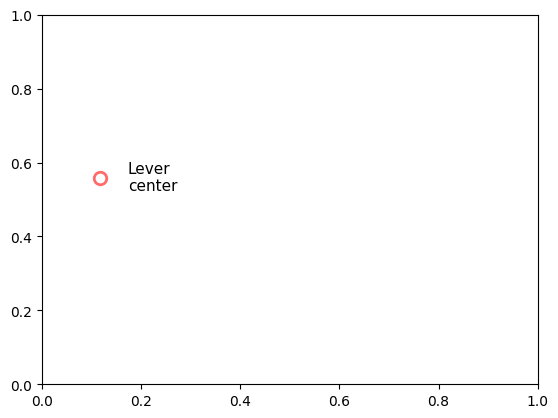

In [126]:
fig, ax =plt.subplots()
from matplotlib.lines import Line2D

def add_leverCenter_legend(ax):
    # Create a list of legend handles with a specified border width
    legend_handles = [Line2D([0], [0], marker='o', color='w', label='Lever\ncenter',
                            markerfacecolor='none', markeredgecolor='#FF6B6B', markersize=9,
                            markeredgewidth=2)]  # Set the border width here

    # Create the legend with the custom handles
    ax.legend(handles=legend_handles,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.18,0.48))

add_leverCenter_legend(ax)

In [127]:
if: 

SyntaxError: invalid syntax (1786429152.py, line 1)

In [128]:
sName = 'jp3269-28112022-0108'
c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())

Original Shape for session  jp3269-28112022-0108  is  46
Shape for session  jp3269-28112022-0108  is  (46, 37)


100%|██████████| 153/153 [00:00<00:00, 377.35it/s]
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:7: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_y'] = testSlice['yPose'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/3353968732.py:9: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_x'] = testSlice['ActualCoordpx'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:10: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_y'] = testSlice['ActualCoordpy'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:7: RuntimeWarning: Mean of empty slice
  testSlice[

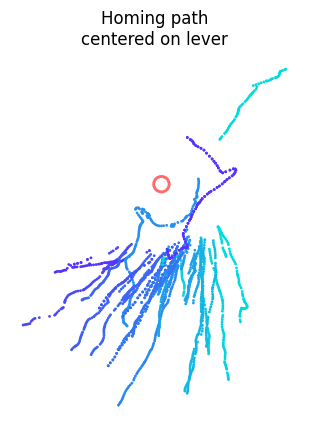

In [129]:
fig, ax0 = plt.subplots()

#Put a lever in the middle
sName = 'jp3269-28112022-0108'
sessionSlice = getSessionSlice(sName)
tNum = 98

homingSlice = getHomingColorPath(sName)
homingSlice = center_on_lever(homingSlice)
plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                    condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True)

plotLeverCenterLegend(ax0)


# Plot supplementary for this figure

In [130]:
def plot_one_column(gs0,cellID,columnNum = 0 ,polarMax=20,yticks=True,ylabel='',title=''):
    ax0 = fig.add_subplot(gs0[0,columnNum])

    plot_left_right_center_on_lever_paths(ax0, cellID,ylabel='',colors = [LEFTCOLOR,RIGHTCOLOR])
    if columnNum == 1:
        plotLeverCenterLegend(ax0,r=3.5,borderW=2.2)
    else:
        plotLeverCenterLegend(ax0)

    ax0.set_title(title)


    ax0 = fig.add_subplot(gs0[1,columnNum],projection='polar')
    
    left, right = get_leftRight(cellID,hdLeverCenteredLeftRightHeadingError, 'all')
        
    plotHdMapTogether_correct(ax0,left,right,colors = [LEFTCOLOR,RIGHTCOLOR],title="",max_num=polarMax,setMaxNum=True)
    ax0.spines['polar'].set_color('none')
    label_mvl_peak_on_polar_plot(ax0,cellID,dfMedianSplitLR,colors = [LEFTCOLOR,RIGHTCOLOR],medianCondition1 = 'belowMedianIntervals',medianCondition2 = 'aboveMedianIntervals')

    ax0 = fig.add_subplot(gs0[2,columnNum]) # add an axes to the figure
    cluid = cellID
    plot_left_right_sorted_heatmap(ax0,cluid,trialMatrixMergedNoNaPlot,fillNan=True,convolution=GLOBALCONV,ylabel=ylabel)

    ax0 = fig.add_subplot(gs0[3,columnNum]) # add an axes to the figure
    cluid = cellID
    plot_trialMatrix_correlation(ax0,cluid,trialMatrixMergedNoNaPlot,var_y='homingDir',set_ylabel=yticks)




# Figure 7

In [131]:
#Loading the file
fn=myProject.dataPath+"/results/myLeverCellStatsSplitBySearchLengthMedian_faster.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    hdLeverCenteredLongShort = pickle.load(fp)  

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/myLeverCellStatsSplitBySearchLengthMedian_faster.pickle


In [132]:
belowOrAboveList = ['aboveMedianIntervals','belowMedianIntervals']
cell_hd_dir_rad_holder = []
cell_hd_dir_deg_holder = []
cell_hd_vector_holder = []
cell_hd_peak_rad_holder = []
cell_hd_peak_rate_holder = []
cluIdList = []
medianConditionList = []
cell_hd_mean_rate = []
diff_radian_holder = []
infoHolder = []
lightHolder = []
intervalHolder = []
histoholder = []


intervalType = 'all'
lightConditionList = ['dark']
for lightCondition in lightConditionList:
    for clu in lever_gc.cluId.unique():
        for belowOrAbove in belowOrAboveList:

            histoByMedian = hdLeverCenteredLongShort[clu][lightCondition][intervalType][belowOrAbove]['Hist']
            cellMeanByMedian = hdLeverCenteredLongShort[clu][lightCondition][intervalType][belowOrAbove]['meanFiring']
            infoByMedian = hdLeverCenteredLongShort[clu][lightCondition][intervalType][belowOrAbove]['infoScore']

            try:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = hdLeverCenteredLongShort[clu][lightCondition][intervalType][belowOrAbove]['hd_score']
            except:
                cell_hd_dir_rad, cell_hd_dir_deg, cell_hd_vector, cell_hd_peak_rad, cell_hd_peak_rate = [np.nan]*5

            cluIdList.append(clu)
            medianConditionList.append(belowOrAbove)
            infoHolder.append(infoByMedian)
            cell_hd_dir_rad_holder.append(cell_hd_dir_rad)
            cell_hd_dir_deg_holder.append(cell_hd_dir_deg)
            cell_hd_vector_holder.append(cell_hd_vector)
            cell_hd_peak_rad_holder.append(cell_hd_peak_rad)
            cell_hd_peak_rate_holder.append(cell_hd_peak_rate)
            cell_hd_mean_rate.append(cellMeanByMedian)
            lightHolder.append(lightCondition)
            intervalHolder.append(intervalType)
            histoholder.append(histoByMedian)

In [133]:
dfMedianSplitLongShort = pd.DataFrame(list(zip(cluIdList,medianConditionList,lightHolder,infoHolder,cell_hd_dir_rad_holder,
                                          cell_hd_dir_deg_holder,cell_hd_vector_holder,cell_hd_peak_rad_holder,
                                          cell_hd_peak_rate_holder,cell_hd_mean_rate,intervalHolder)),
                 columns = ['cluId','medianCondition','lightCondition','infoScore',
                            'hd_dir_rad','hd_dir_deg','hd_vector','hd_peak_rad','hd_peak_rate','hd_mean_rate','intervalType'])

In [134]:
dfMedianSplitLongShort['sessionName'] = dfMedianSplitLongShort['cluId'].apply(lambda x: x.split('_')[0])

In [135]:
dfMedianSplitLongShort['mouse'] = dfMedianSplitLongShort['cluId'].apply(lambda x: x.split('-')[0])

In [136]:
histoDf = pd.DataFrame(np.array(histoholder),columns = [f'histo_bin_{j+1}' for j in range(36)])

In [137]:
dfMedianSplitLongShort = pd.concat([dfMedianSplitLongShort,histoDf],axis=1)

In [138]:
exclude_cluIds = list(dfMedianSplitLongShort[dfMedianSplitLongShort.hd_vector.isnull()]['cluId'])
dfMedianSplitLongShort = dfMedianSplitLongShort[~dfMedianSplitLongShort['cluId'].isin(exclude_cluIds)].reset_index(drop=True)

In [139]:
def plot_long_short_paths(ax,input_cell_id,title='',ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR]):
    cell_id = input_cell_id
    mouseName = cell_id.split('-')[0]
    sessionName = cell_id.split('_')[0]
    tempRes = res[(res.sessionName == sessionName)&(res.light == 'dark')].reset_index().copy()
    tempRes = tempRes.dropna(subset = 'searchLength') 

    
    instantaneousVariablesTemp = pd.read_csv(f'/adata/electro/{mouseName}/{sessionName}/navPathInstan.csv')
    instantaneousVariablesTemp['condition'] = instantaneousVariablesTemp.name.apply(lambda x: x.split('_')[2])
    
    fn = f'/adata/electro/{mouseName}/{sessionName}/navPathSummary.csv'
    navPathSummary = pd.read_csv(fn)

    mergedDf = get_merge_dataframe(navPathSummary, tempRes)
    
    #print(mergedDf)
    
    homingPeriMedianSlice = mergedDf.searchLength.median()
    mergedDf['belowMedian'] = np.where(mergedDf['searchLength']<homingPeriMedianSlice, True, False)

    correctList = mergedDf[mergedDf.belowMedian].trialNo_x.unique()
    incorrectList = mergedDf[~mergedDf.belowMedian].trialNo_x.unique()
    
    inCorrect_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(incorrectList))&(instantaneousVariablesTemp.condition == 'searchToLeverPath')]
    Correct_instanSlice = instantaneousVariablesTemp[(instantaneousVariablesTemp.trialNo.isin(correctList))&(instantaneousVariablesTemp.condition == 'searchToLeverPath')]
    
    lw=2
    for t in inCorrect_instanSlice.trialNo.unique():
        plotDf = inCorrect_instanSlice[inCorrect_instanSlice.trialNo ==t]
        ax.plot(plotDf['x'],plotDf['y'],c=colors[1],alpha=0.8,lw=lw)
    
    for t in Correct_instanSlice.trialNo.unique():
        plotDf = Correct_instanSlice[Correct_instanSlice.trialNo ==t]
        ax.plot(plotDf['x'],plotDf['y'],c=colors[0],alpha=0.8,lw=lw)
        
    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')  
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'{title}')
    ax.set_ylabel(ylabel)
    
def get_longShort(gl_cell,inputHist,intervalType = 'all'):
    clu = gl_cell
    lightCondition = 'dark'


    belowOrAbove = 'belowMedianIntervals'
    belowHist = inputHist[clu][lightCondition][intervalType][belowOrAbove]['Hist']

    belowOrAbove = 'aboveMedianIntervals'
    aboveHist = inputHist[clu][lightCondition][intervalType][belowOrAbove]['Hist']
    
    return belowHist,aboveHist

In [140]:
def plotmap(axes, cluId, maps,showYLabel=True):
    mapindex=ct[ct.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps['circ80_1'][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')


    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [141]:
def plot_short_long_heatmap(ax,cluid,inputDf,shortOrLong = 'short',lightCondition='dark',fillNan = False,ylabel='Trials',x_simplify=False,title='',get_conv=False):
    
    plotSlice = inputDf[(inputDf.cluId == cluid)&(inputDf.lightCondition == lightCondition)].copy()
    plotSlice.insert(0,'shortOrLong',np.where(plotSlice.searchLength < plotSlice.searchLength.median(), 'short', 'long'))  
    plotSlice = plotSlice[plotSlice.sumOfHistos>20]
    
   
    
    sortSlice = plotSlice.sort_values(by='searchLength',ascending=True)
    sortSlice = sortSlice[sortSlice.shortOrLong == shortOrLong].reset_index().copy()
    
    
    heatmapSlice = np.array(sortSlice.iloc[:,-36:])
    if fillNan:
        heatmapSlice = np.apply_along_axis(interpolate_histogram,axis=1,arr= heatmapSlice)
        
    if get_conv:
        heatmapSlice = get_convolution_heatmap(heatmapSlice)
        heatmapSlice = normalize_2d_array(heatmapSlice)
        sns.heatmap(heatmapSlice,cmap='viridis',cbar=False,ax=ax)
    else:
        shiftIndex = np.argmax(np.nanmean(heatmapSlice,axis=0))
        sns.heatmap(np.roll(heatmapSlice,18-shiftIndex,axis=1),cmap='viridis',cbar=False,ax=ax)
    
    ax.set_xticks(ticks=[0, 18, 36])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    if x_simplify:
        ax.set_xticks(ticks=[])
        ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title(title)

In [142]:
def plot_long_shortsingle_cell_figure(gs0):

    #Examples
    cell1 = 'mn8578-17122021-0107_74'
    cell2 = 'jp486-24032023-0108_490' 
    cell3 = 'jp486-26032023-0108_751' 
    cell4 = 'jp3269-27112022-0108_569'

    nansInTheHistos = trialMatrixMerged.iloc[:,-36:].isna().sum(axis=1)
    threshold = 5
    trialMatrixMergedNoNaPlot = trialMatrixMerged[nansInTheHistos<threshold].copy()
    trialMatrixMergedNoNaPlot.insert(0,'sumOfHistos',np.nansum(trialMatrixMergedNoNaPlot.iloc[:,-36:].values,axis=1)) 
    trialMatrixMergedNoNaPlot = trialMatrixMergedNoNaPlot[trialMatrixMergedNoNaPlot.sumOfHistos > 20]


    #First Row
    ax0 = fig.add_subplot(gs0[0,1])
    cellID = cell1
    plot_long_short_paths(ax0, cellID,ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR])



    ax0 = fig.add_subplot(gs0[0,2],projection='polar')
    short, long = get_longShort(cellID,hdLeverCenteredLongShort, 'all')
    plotHdMapTogether_correct(ax0,short,long,title="",max_num=30,colors = [LOWERCOLOR,HIGHERCOLOR])
    ax0.spines['polar'].set_color('none')

    label_mvl_peak_on_polar_plot(ax0,cellID,dfMedianSplitLongShort,colors = [LOWERCOLOR,HIGHERCOLOR],
                                 medianCondition1 = 'belowMedianIntervals',medianCondition2 = 'aboveMedianIntervals',y1=0.20,y2=0.10)

    ax0 = fig.add_subplot(gs0[0,3])
    plotmap(ax0,cellID,myMaps) 

    ax0 = fig.add_subplot(gs0[0,4])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'short',fillNan=True,title='Short',x_simplify=True,get_conv=True)
    ax0 = fig.add_subplot(gs0[0,5])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'long',fillNan=True,ylabel='',title='Long',x_simplify=True,get_conv=True)

    #Second Row
    ax0 = fig.add_subplot(gs0[1,1])
    cellID = cell2
    plot_long_short_paths(ax0, cellID,ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR])

    ax0 = fig.add_subplot(gs0[1,2],projection='polar')
    short, long = get_longShort(cellID,hdLeverCenteredLongShort, 'all')
    plotHdMapTogether_correct(ax0,short,long,title="",max_num=30,colors = [LOWERCOLOR,HIGHERCOLOR])
    ax0.spines['polar'].set_color('none')

    label_mvl_peak_on_polar_plot(ax0,cellID,dfMedianSplitLongShort,colors = [LOWERCOLOR,HIGHERCOLOR],
                                 medianCondition1 = 'belowMedianIntervals',medianCondition2 = 'aboveMedianIntervals',y1=0.20,y2=0.10)

    ax0 = fig.add_subplot(gs0[1,3])
    plotmap(ax0,cellID,myMaps)   

    ax0 = fig.add_subplot(gs0[1,4])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'short',fillNan=True,x_simplify=True,get_conv=True)

    ax0 = fig.add_subplot(gs0[1,5])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'long',fillNan=True,ylabel='',x_simplify=True,get_conv=True)

    #Third Row
    ax0 = fig.add_subplot(gs0[2,1])
    cellID = cell3
    plot_long_short_paths(ax0, cellID,ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR])

    ax0 = fig.add_subplot(gs0[2,2],projection='polar')
    short, long = get_longShort(cellID,hdLeverCenteredLongShort, 'all')
    plotHdMapTogether_correct(ax0,short,long,title="",max_num=30,colors = [LOWERCOLOR,HIGHERCOLOR])
    ax0.spines['polar'].set_color('none')

    label_mvl_peak_on_polar_plot(ax0,cellID,dfMedianSplitLongShort,colors = [LOWERCOLOR,HIGHERCOLOR],
                                 medianCondition1 = 'belowMedianIntervals',medianCondition2 = 'aboveMedianIntervals',y1=0.20,y2=0.10)

    ax0 = fig.add_subplot(gs0[2,3])
    plotmap(ax0,cellID,myMaps)   

    ax0 = fig.add_subplot(gs0[2,4])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'short',fillNan=True,x_simplify=True,get_conv=True)

    ax0 = fig.add_subplot(gs0[2,5])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'long',fillNan=True,ylabel='',x_simplify=True,get_conv=True)


    #Fourth Row
    ax0 = fig.add_subplot(gs0[3,1])
    cellID = cell4
    plot_long_short_paths(ax0, cellID,ylabel='',colors = [LOWERCOLOR,HIGHERCOLOR])

    ax0 = fig.add_subplot(gs0[3,2],projection='polar')
    short, long = get_longShort(cellID,hdLeverCenteredLongShort, 'all')
    plotHdMapTogether_correct(ax0,short,long,title="",max_num=30,colors = [LOWERCOLOR,HIGHERCOLOR])
    ax0.spines['polar'].set_color('none')

    label_mvl_peak_on_polar_plot(ax0,cellID,dfMedianSplitLongShort,colors = [LOWERCOLOR,HIGHERCOLOR],
                                 medianCondition1 = 'belowMedianIntervals',medianCondition2 = 'aboveMedianIntervals',y1=0.20,y2=0.10)

    ax0 = fig.add_subplot(gs0[3,3])
    plotmap(ax0,cellID,myMaps)   

    ax0 = fig.add_subplot(gs0[3,4])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'short',fillNan=True,get_conv=True)
    ax0 = fig.add_subplot(gs0[3,5])
    plot_short_long_heatmap(ax0,cellID,trialMatrixMergedNoNaPlot,shortOrLong = 'long',fillNan=True,ylabel='',get_conv=True)

In [143]:
def get_convolution_heatmap(inputHeatmap):
    shiftedArrayHolder = []
    for i in range(0,inputHeatmap.shape[0]):
        heatmapSlice = np.array(inputHeatmap[i,:])
        shiftIndex = np.argmax(heatmapSlice)
        shiftedArray = np.roll(heatmapSlice,18-shiftIndex).astype(float)
        shiftedArray = interpolate_histogram(shiftedArray)
        shiftedArrayHolder.append(shiftedArray)

    shiftedCenterArray = np.array(shiftedArrayHolder)
    shiftedMeanArray = np.nanmean(shiftedCenterArray,axis=0)
    
    corArrayHolder = []
    shiftedMeanArray = interpolate_histogram(shiftedMeanArray)

    shiftIndex = np.argmax(np.nanmean(inputHeatmap[:,:],axis=0))

    for i in range(0,inputHeatmap.shape[0]): 

        heatmapSlice = np.array(inputHeatmap[i,:]).astype(float)

        interHeatmap = interpolate_histogram(heatmapSlice)
        interHeatmap = np.roll(interHeatmap,18-shiftIndex) #This centers the array

        crossCor = np.correlate(interHeatmap,shiftedMeanArray,mode='same')
        corArrayHolder.append(crossCor)
        
    return corArrayHolder

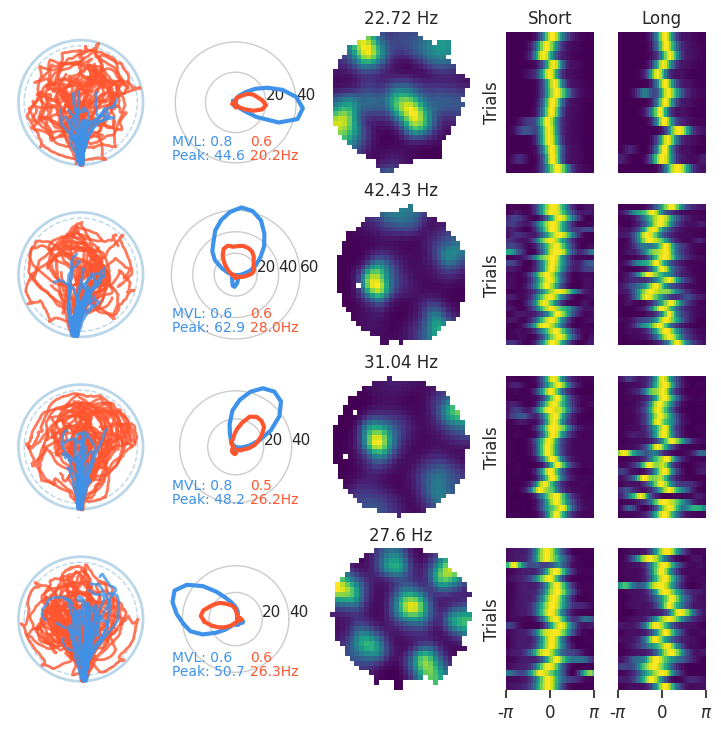

In [144]:
from matplotlib.image import imread

nrows = 8
ncols = 4
colSize = 1.8
rowSize = 1.8
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_theme(style = 'ticks')

LEFTCOLOR = '#FF9F1C'
RIGHTCOLOR = '#2EC4B6'

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+1,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
def add_lr_legend(ax):
    legend_labels = ['Short search','Long search']
    legend_colors = [LOWERCOLOR,HIGHERCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.17,1.1))
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,
colors = ['#845EC2','#FF6F91','#FFC75F','#F9F871']
#Set the color for this figure

#sizePerRow, sizePerCol = figurePanelDefaultSize()

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(4,6,subplot_spec= gs[:4,:],width_ratios = [0.05,1,1,1,0.6,0.6])
plot_long_shortsingle_cell_figure(gs0)

Kolmogorov-Smirnov Test Statistic: 0.2638888888888889
P-value: 7.492003007301808e-27
The two datasets are significantly different.
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Short search vs. Long search: Wilcoxon test (paired samples), P_val:1.238e-03 Stat=4.200e+01


/tmp/ipykernel_862217/2627509278.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=inputDf,x="timeBinName",y="absMvtDirError",edgecolor="black",palette=['#0b8793'],s=7,ax=ax,**stripplot_kwargs)
/tmp/ipykernel_862217/2627509278.py:3: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=inputDf,x="timeBinName",y="absMvtDirError",edgecolor="black",palette=['#0b8793'],s=7,ax=ax,**stripplot_kwargs)


friedmanchisquare stats31.30000000000001 P =7.349668844628159e-07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Short search vs. Long search: Wilcoxon test (paired samples), P_val:2.393e-04 Stat=3.000e+01


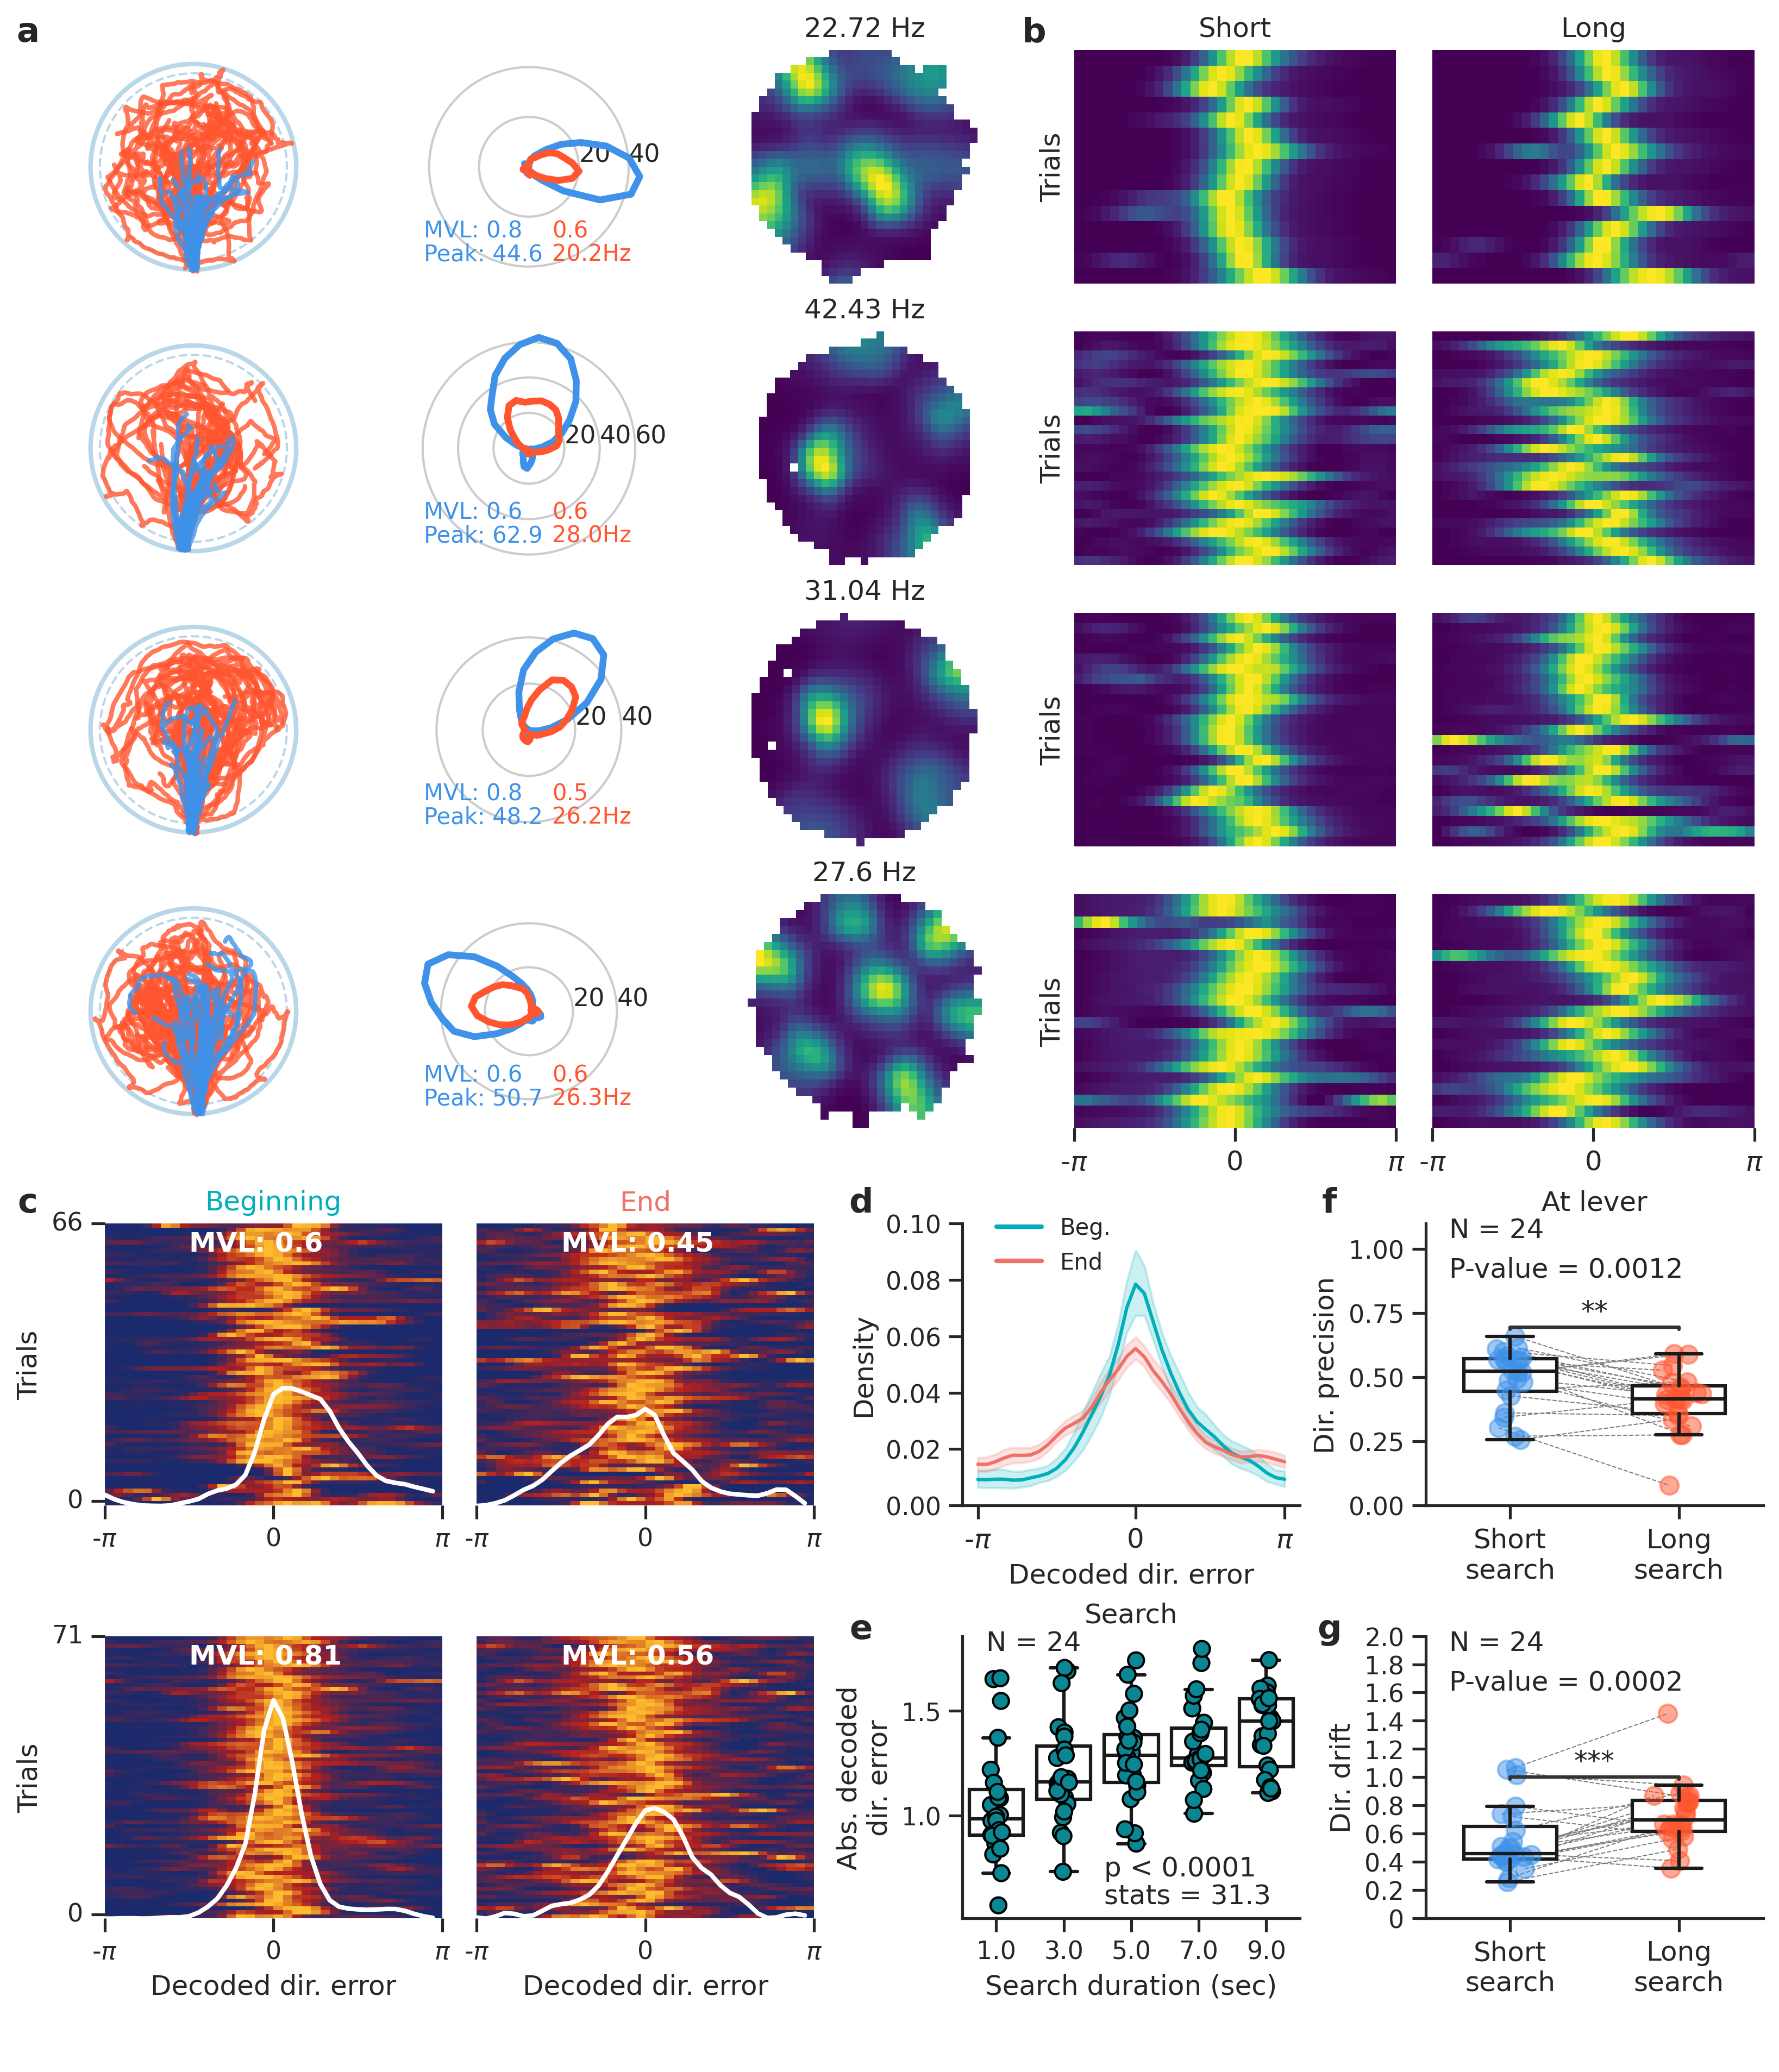

In [145]:
from matplotlib.image import imread
from matplotlib.lines import Line2D

nrows = 7
ncols = 6
colSize = 1.8
rowSize = 1.8
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

LEFTCOLOR = '#FF9F1C'
RIGHTCOLOR = '#2EC4B6'
BEGCOLOR = '#00AFB9'
ENDCOLOR = '#F07167'

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+3,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
def add_ls_legend(ax):
    legend_labels = ['Short search','Long search']
    legend_colors = [LOWERCOLOR,HIGHERCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.12,1.1))
    
def add_beg_end_legend(ax):
    legend_labels = ['Search beg.','Search end']
    legend_colors = [BEGCOLOR,ENDCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.18,0.95))
    

def add_lr_legend(ax):
    legend_labels = ['Left homing','Right homing']
    legend_colors = [LEFTCOLOR,RIGHTCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.18,0.58))

def add_leverCenter_legend(ax):
    # Create a list of legend handles with a specified border width
    legend_handles = [Line2D([0], [0], marker='o', color='w', label='Lever\ncenter',
                            markerfacecolor='none', markeredgecolor='#FF6B6B', markersize=7,
                            markeredgewidth=2.2)]  # Set the border width here

    # Create the legend with the custom handles
    ax.legend(handles=legend_handles,fontsize= GLOBALFONTSIZE-1, frameon=True,loc='lower center', bbox_to_anchor = (0.197,0.502))
        


fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

gs0_top = gridspec.GridSpecFromSubplotSpec(3,4,subplot_spec= gs[4:7,:],width_ratios = [1,1,1,1],height_ratios=[1,1,0.2])
gsExamples = gridspec.GridSpecFromSubplotSpec(4,6,subplot_spec= gs[:4,:],width_ratios = [0.05,1,1,1,1,1])

plot_long_shortsingle_cell_figure(gsExamples)

gs1 = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec= gs[:2,5:],hspace=0)

gs4 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])
gs5 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])
gs6 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])


#Top figure
plot_long_short_search_no_examples(gs0_top, startPoint=0)

#Bottom figure


ax0 = fig.add_subplot(gs6[:,:])
# # #Add figure legend
add_text(ax0,0,1.02,'a',fw='bold')

add_text(ax0,0.58,1.02,'b',fw='bold')

add_text(ax0,0,0.43,'c',fw='bold')

add_text(ax0,0.48,0.43,'d',fw='bold')
add_text(ax0,0.48,0.215,'e',fw='bold')
add_text(ax0,0.75,0.43,'f',fw='bold')
add_text(ax0,0.75,0.215,'g',fw='bold')

ax0.axis('off')

plt.savefig('../../Output/Figure7.pdf', bbox_inches='tight', dpi=300)

In [146]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# Figure 8

In [147]:
import scipy
def custom_stripplot(ax, dfMedianSplit_levergc, light ='dark',var = 'hd_vector',jitter=0.05, alpha=0.5, 
                     ms=8, mew=1, linewidth=0.5, linestyle='--', colors=None,ylim=0.8,ylabel='',accSplit = 'acc',Circular=False,title=''):
    if accSplit == 'acc':
        splitVariable = ['Accurate homing','Inaccurate homing']
    elif accSplit == 'leftRight':
        splitVariable = ['Left homing','Right homing']
    elif accSplit == 'longShort':
        splitVariable = ['Short search','Long search']
        
    if Circular:
        def mySummary(df):        
            angles = df[f"{var}"]

            # Calculate the sum of unit vectors
            sum_x = sum(math.cos(θ) for θ in angles)
            sum_y = sum(math.sin(θ) for θ in angles)

            # Calculate the angle of the resulting sum vector
            circular_mean_angle = math.atan2(sum_y, sum_x)
            
            error = math.remainder(circular_mean_angle,math.tau)
            
            return pd.DataFrame({f"{var}": [error]})
    else:
        def mySummary(df):        
            error = np.nanmean(df[f"{var}"])        
            return pd.DataFrame({f"{var}": [error]})
        
    df_combined = dfMedianSplit_levergc.groupby(['mouse','lightCondition','medianCondition']).apply(mySummary).reset_index()
    
    processDf = df_combined[df_combined.lightCondition == light].copy()

    aggregatedMVL = pd.pivot_table(data=processDf,values = var,index='mouse',columns='medianCondition').reset_index()
    if accSplit == 'acc':
        aggMvlNumpy = aggregatedMVL.loc[:,['Accurate homing','Inaccurate homing']].values
    elif accSplit == 'leftRight':
        aggMvlNumpy = aggregatedMVL.loc[:,['Left homing','Right homing']].values
    elif accSplit == 'longShort':
        aggMvlNumpy = aggregatedMVL.loc[:,['Short search','Long search']].values
        
        
    df = pd.DataFrame(aggMvlNumpy)

    df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
    df_x_jitter += np.arange(len(df.columns))
    
    
    #Boxplot

    if accSplit == 'acc':
        processDf.replace({'Accurate homing':'Accurate\nhoming', 'Inaccurate homing':'Inaccurate\nhoming'},inplace=True)
    elif accSplit == 'leftRight':
        processDf.replace({'Left homing':'Left\nhoming', 'Right homing':'Right\nhoming'},inplace=True)
    elif accSplit == 'longShort':
        processDf.replace({'Short search':'Short\nsearch', 'Long search':'Long\nsearch'},inplace=True)
    
    if accSplit == 'acc':
        
        order = ['Accurate\nhoming','Inaccurate\nhoming']
    elif accSplit == 'leftRight':
        order =['Left\nhoming','Right\nhoming']
    elif accSplit == 'longShort':
        order =['Short\nsearch','Long\nsearch']

    b = sns.boxplot(data=processDf,x = 'medianCondition', y = var, ax=ax, palette=['white'],order = order,width=0.55,showfliers=False, **boxplot_kwargs)
    
    p = processDf['medianCondition'].unique()
    
    pairs = [(p[0],p[1])]
    annotator = Annotator(b, pairs, data=processDf, 
                          x = 'medianCondition', y = var,order = order)

    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    for i, col in enumerate(df):
        if colors is not None:
            color = colors[i]
        else:
            color = 'C{}'.format(i)  # Use default Matplotlib color cycle

        ax.plot(df_x_jitter[col], df[col], 'o', alpha=alpha, zorder=1, ms=ms, mew=mew, color=color)

    ax.set_xticks(range(len(df.columns)))

    ax.set_xlim(-0.5, len(df.columns) - 0.5)

    for idx in df.index:
        for i in range(0, len(df.columns), 2):
            ax.plot(df_x_jitter.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    df.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    color='grey', linewidth=linewidth, linestyle=linestyle, zorder=-1)
            
    
    
    ax.set_xticklabels(order,fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(ylim)
    ax.set_title(title)
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    
    number = len(processDf.mouse.unique())
    
    res = scipy.stats.wilcoxon(processDf[processDf.medianCondition == order[0]][var].values,processDf[processDf.medianCondition == order[1]][var].values)
    
    ax.text(0.07,0.98, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    ax.text(0.07,0.86, f'P-value = {round(res[1],6)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

In [148]:
def simplified_long_format_model_figure(gs,fig,startCol = 0):
    
    bdColor = '#edede9'

    #Search Example
    ax0 = fig.add_subplot(gs[0,startCol]) 
    
    sName = 'jp452-24112022-0109'
    sessionSlice = getSessionSlice(sesName = sName)
    tNum = 106

    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True,noTitle=True)
    
    ax0.set_title(' ')
    plotLeverCenterLegend(ax0)
    
    
    gs0_heatmapSlice1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[1,startCol],width_ratios=[0.1,0.1,1],wspace=0)
    

    ax0 = fig.add_subplot(gs0_heatmapSlice1[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'searchToLeverPath_dark')
    ax0.set_ylabel('Trials')
    

    ax0 = fig.add_subplot(gs0_heatmapSlice1[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'searchToLeverPath_dark',set_ticks=True,xlabel='Dec. dir. error',ylabel='')
    ax0.set_title('Search')
    
    
    ax0 = fig.add_subplot(gs[2,startCol])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_kdeplot(ax0,c_statsDf,ylabel='Homing heading',xlabel='Decoded trial drift',var_x = 'searchRad',var_y='homingDir',c='#cfbaf0')
    ax0.set_title('Search')
    
    #At Lever Example
    ax0 = fig.add_subplot(gs[0,startCol+1]) 
    sName = 'jp451-28102022-0108'
    sessionSlice = getSessionSlice(sesName = sName)
    tNum = 32

    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True,noTitle=True)
    ax0.set_title(' ')
    
    plotLeverCenterLegend(ax0)
    
    

    
    gs0_heatmapSlice2 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[1,startCol+1],width_ratios=[0.1,0.1,1],wspace=0)

    ax0 = fig.add_subplot(gs0_heatmapSlice2[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'atLever_dark')
    

    ax0 = fig.add_subplot(gs0_heatmapSlice2[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'atLever_dark',set_ticks=True,ylabel='',xlabel='Dec. dir. error')
    ax0.set_title('At lever')

    ax0 = fig.add_subplot(gs[2,startCol+1])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_kdeplot(ax0,c_statsDf,ylabel='Homing heading',xlabel='Decoded trial drift',var_x = 'atLeverRad',var_y='homingDir', set_ylabel= False,c='#cfbaf0')
    ax0.set_title('At lever')

    #Homing example
    ax0 = fig.add_subplot(gs[0,startCol+2]) 
    sName = 'jp3269-28112022-0108'
    sessionSlice = getSessionSlice(sName)
    tNum = 98
    
    homingSlice = getHomingColorPath(sName)
    homingSlice = center_on_lever(homingSlice)
    plot_path_with_colors_in_grid_space(ax0,homingSlice[homingSlice.condition == 'homingFromLeavingLeverToPeriphery_dark'],
                                        condition='homingFromLeavingLeverToPeriphery_dark',predicted=False,trial=None,transform=True,centerOnLever=True,noTitle=True)
    ax0.set_title(' ')
    plotLeverCenterLegend(ax0,r=3,borderW=2.2)

    
    
    
    gs0_heatmapSlice3 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[1,startCol+2],width_ratios=[0.1,0.1,1],wspace=0)
    
    ax0 = fig.add_subplot(gs0_heatmapSlice3[0,1]) 
    plot_model_prediction_headingDir_colorbar(ax0,sName,'homingFromLeavingLeverToPeriphery_dark')
    

    ax0 = fig.add_subplot(gs0_heatmapSlice3[0,2]) 
    plot_model_prediction_heatmap(ax0,sName,'homingFromLeavingLeverToPeriphery_dark',set_ticks=True,ylabel='',xlabel='Dec. dir. error')
    ax0.set_title('Homing')
    
    ax0 = fig.add_subplot(gs[2,startCol+2])
    c_statsDf = get_circular_stats_dataFrame(sName,allSessionDf.copy(),res.copy())
    plot_kdeplot(ax0,c_statsDf,ylabel='Homing\nheading',xlabel='Decoded trial drift',var_x = 'homingRad',var_y='homingDir', set_ylabel= False,c='#cfbaf0')
    ax0.set_title('Homing')

    #Plot the distribution plot on the fourth row
    ax0 = fig.add_subplot(gs[3,0])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'searchRad'],xValue='realR',xLabel = 'Dec. rot.-homing\nheading corr.',ylabel='Sessions',legend=True,removeX=False,legendToLower=False,ylim=10,plotP=True)
    ax0.set_title('Search')

    ax0 = fig.add_subplot(gs[3,1])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'atLeverRad'],xValue='realR',xLabel = 'Dec. rot.-homing\nheading corr.',ylabel='',legend=False,removeX=False,removeY=False,plotP=True)
    ax0.set_title('At lever')

    ax0 = fig.add_subplot(gs[3,2])
    plot_TrialMatrix_histplot(ax0,allSessionModelDf[allSessionModelDf.shiftCondition == 'homingRad'],xValue='realR',xLabel = 'Dec. rot.-homing\nheading corr.',ylabel='',legend=False,removeY=False,removeX=False,ylim=8,plotP=True)
    ax0.set_title('Homing')

In [149]:
def plot_long_format_left_right_simple(gs0,startPoint=0):

    #Examples
    cell1 = 'jp486-24032023-0108_608'
    cell2 = 'jp451-27102022-0108_189'
    cell3 = 'mn8578-17122021-0107_233'

    #First Row
    plot_one_column(gs0,cell1,columnNum = 0,ylabel='Trials',title=' ')

    plot_one_column(gs0,cell2,columnNum = 1,polarMax=16,yticks=False,title=' ')

    plot_one_column(gs0,cell3,columnNum = 2,yticks=False,title=' ')

/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
100%|██████████| 106/106 [00:00<00:00, 365.77it/s]
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:7: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_y'] = testSlice['yPose'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/33539

Original Shape for session  jp452-24112022-0109  is  31
Shape for session  jp452-24112022-0109  is  (31, 37)


/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
100%|██████████| 127/127 [00:00<00:00, 360.21it/s]
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:7: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_y'] = testSlice['yPose'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/3353968732.py:9: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_x'] = testSlice['ActualCoordpx'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:10: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_y'] = testSlice['ActualCoordpy'] - np.nanmean(testSlice['leverY_y'])
100%|██████████| 43/43 [00:00<00:00, 698.80it/s]


Original Shape for session  jp451-28102022-0108  is  39
Shape for session  jp451-28102022-0108  is  (39, 37)


/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
100%|██████████| 153/153 [00:00<00:00, 371.23it/s]
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_x'] = testSlice['xPose'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:7: RuntimeWarning: Mean of empty slice
  testSlice['pathCenterOnLever_y'] = testSlice['yPose'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/3353968732.py:9: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_x'] = testSlice['ActualCoordpx'] - np.nanmean(testSlice['leverX_y'])
/tmp/ipykernel_862217/3353968732.py:10: RuntimeWarning: Mean of empty slice
  testSlice['pred_pathCenterOnLever_y'] = testSlice['ActualCoordpy'] - np.nanmean(testSlice['leverY_y'])
/tmp/ipykernel_862217/3353968732.py:6: RuntimeWarning: Mea

Original Shape for session  jp3269-28112022-0108  is  46
Shape for session  jp3269-28112022-0108  is  (46, 37)


/home/kilo/miniconda3/envs/my_custom_environment/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


stats, p 19.0, 3.6597251892089844e-05
stats, p 0.0, 1.1920928955078125e-07
stats, p 20.0, 4.4226646423339844e-05


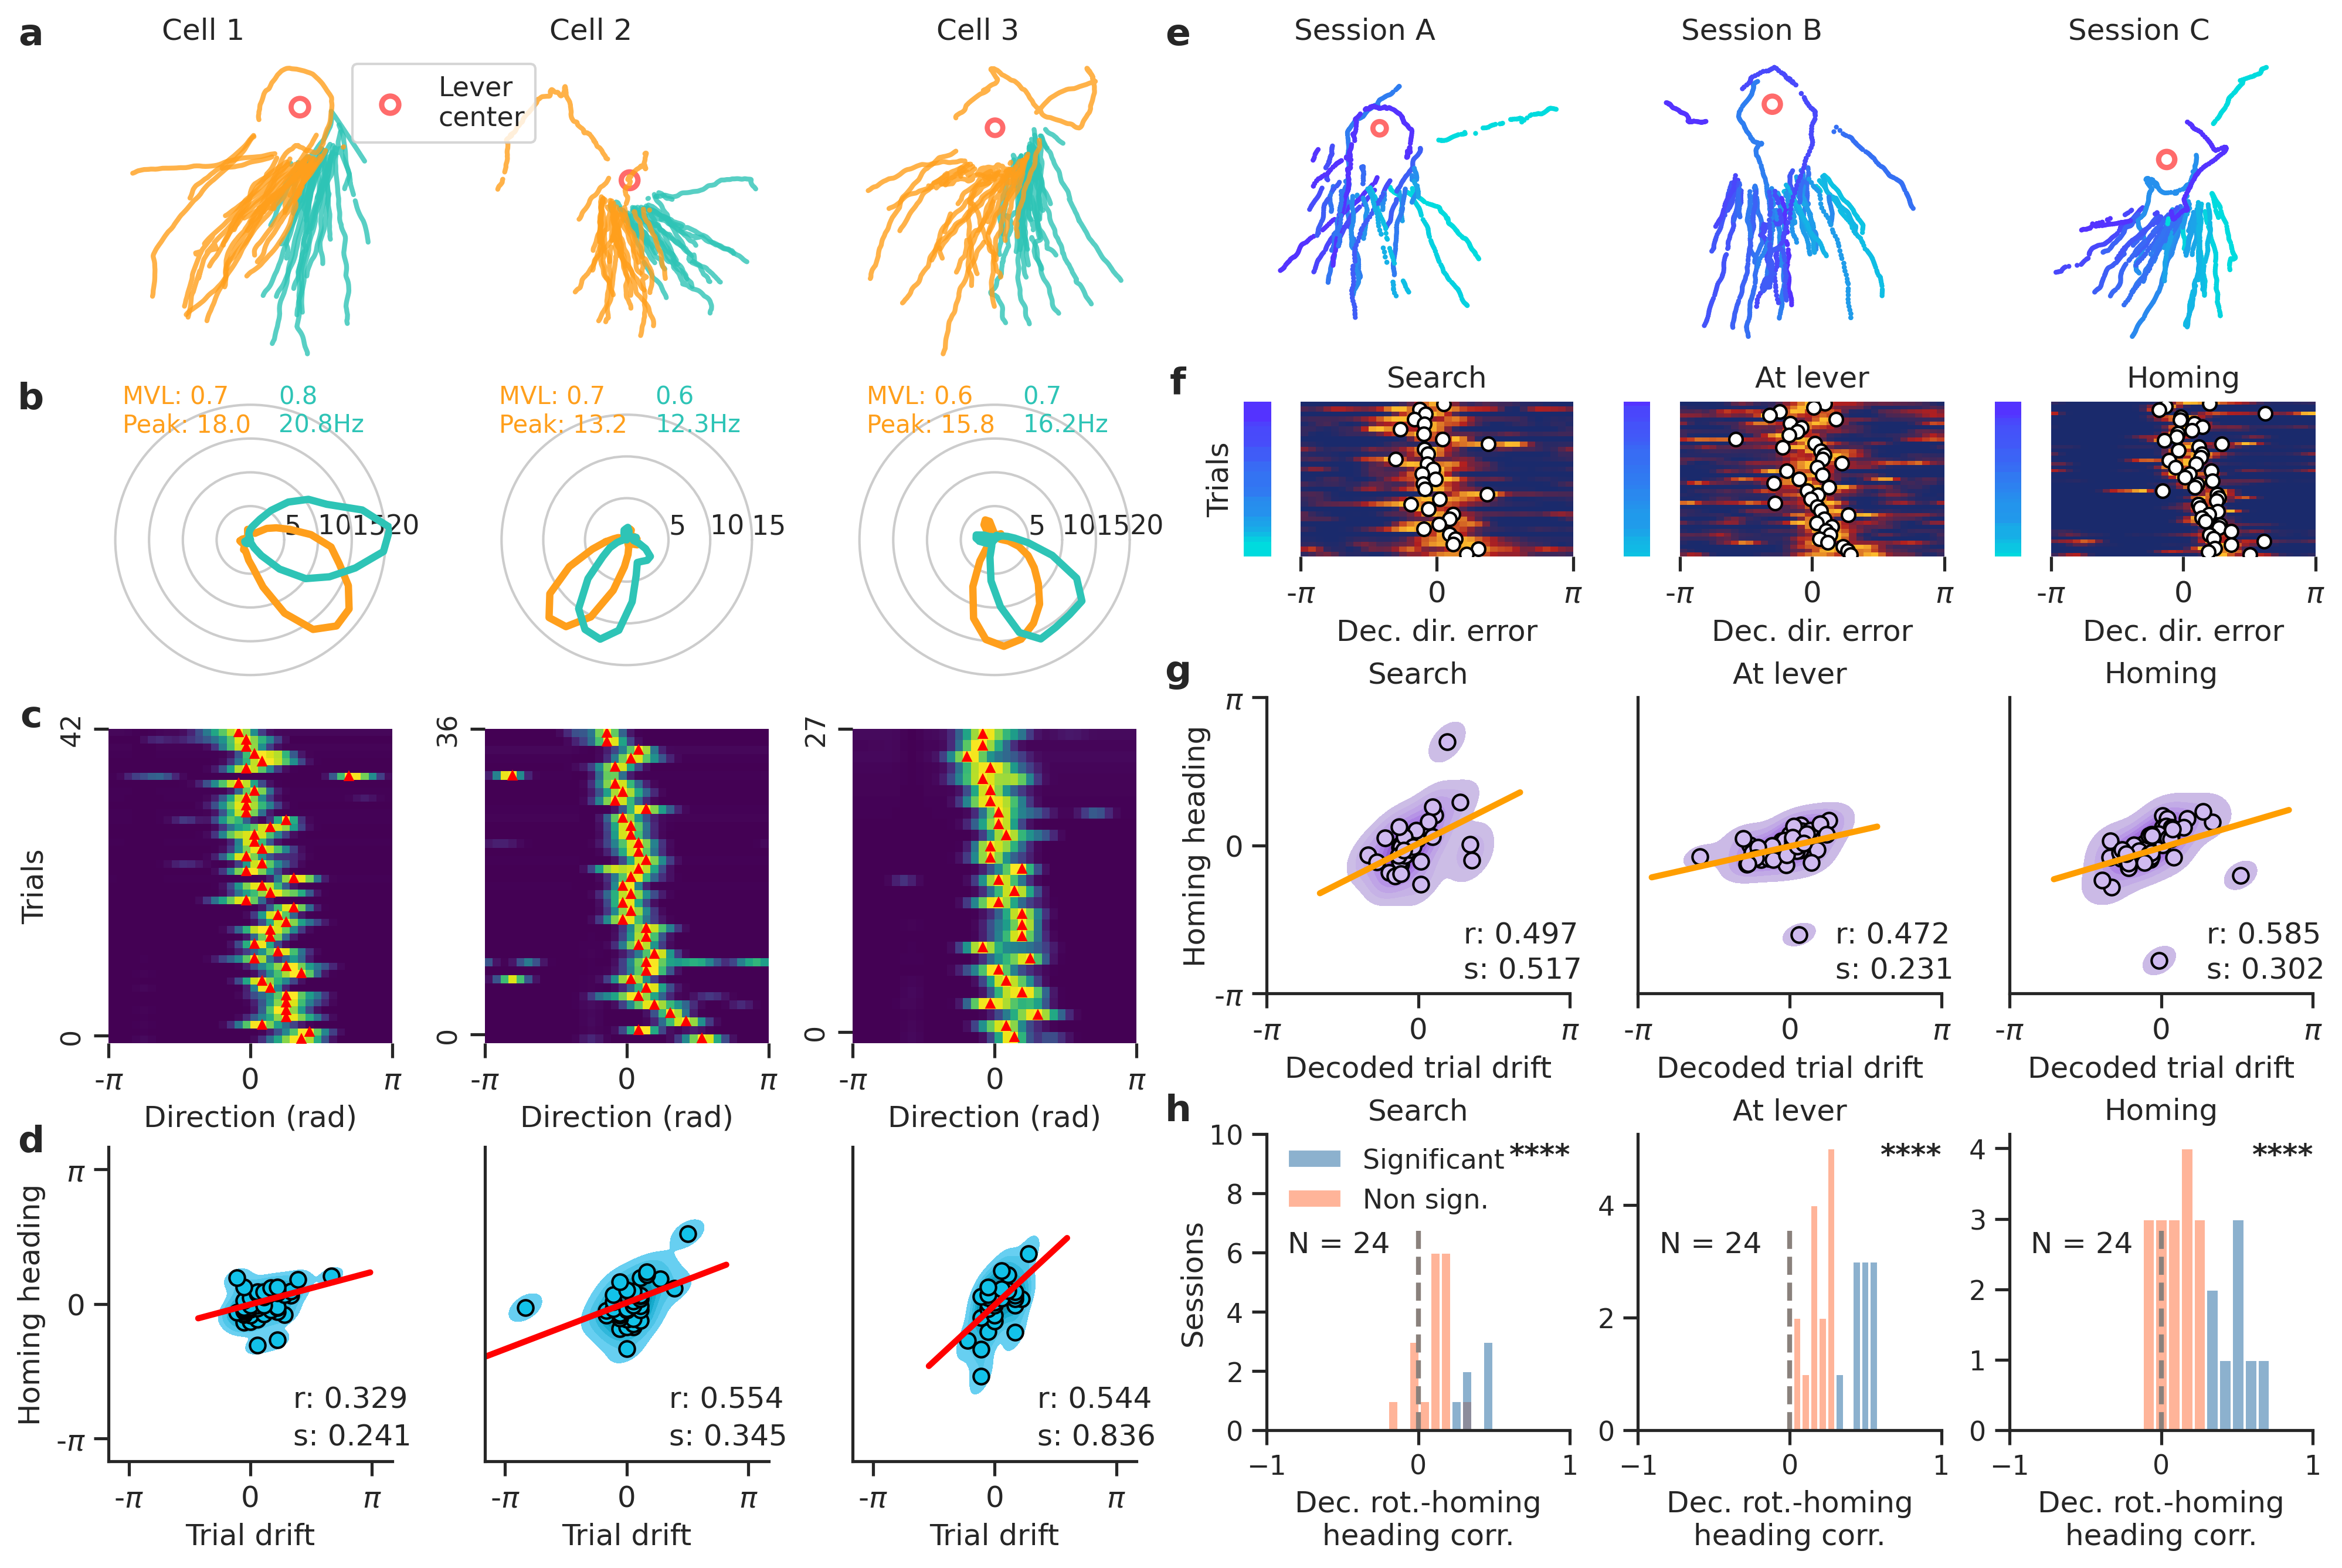

In [150]:
from matplotlib.image import imread
from matplotlib.lines import Line2D

nrows = 4
ncols = 6
colSize = 2.2
rowSize = 2.2
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

LEFTCOLOR = '#FF9F1C'
RIGHTCOLOR = '#2EC4B6'
BEGCOLOR = '#00AFB9'
ENDCOLOR = '#F07167'

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+3.2,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
def add_ls_legend(ax):
    legend_labels = ['Short search','Long search']
    legend_colors = [LOWERCOLOR,HIGHERCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.12,1.1))
    
def add_beg_end_legend(ax):
    legend_labels = ['Search beg.','Search end']
    legend_colors = [BEGCOLOR,ENDCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.18,0.95))
    

def add_lr_legend(ax):
    legend_labels = ['Left homing','Right homing']
    legend_colors = [LEFTCOLOR,RIGHTCOLOR]

    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]

    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-1, frameon=False,loc='lower center', bbox_to_anchor = (0.18,0.58))

def add_leverCenter_legend(ax):
    # Create a list of legend handles with a specified border width
    legend_handles = [Line2D([0], [0], marker='o', color='w', label='Lever\ncenter',
                            markerfacecolor='none', markeredgecolor='#FF6B6B', markersize=7,
                            markeredgewidth=2.2)]  # Set the border width here

    # Create the legend with the custom handles
    ax.legend(handles=legend_handles,fontsize= GLOBALFONTSIZE-1, frameon=True,loc='lower center', bbox_to_anchor = (0.18,0.92))
        


fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

gs0_top = gridspec.GridSpecFromSubplotSpec(4,3,subplot_spec= gs[:,:3])
gs0_bottom = gridspec.GridSpecFromSubplotSpec(4,3,subplot_spec= gs[:,3:])



gs1 = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec= gs[:2,5:],hspace=0)

gs4 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])
gs5 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])
gs6 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])


# Top figure
plot_long_format_left_right_simple(gs0_top, startPoint=0)

# Bottom figure
simplified_long_format_model_figure(gs0_bottom,fig,startCol=0)

# Add title for left figure
gs0_left_right_title = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[:,:3])

ax0 = fig.add_subplot(gs0_left_right_title[0,0])
ax0.set_title('Cell 1',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

ax0 = fig.add_subplot(gs0_left_right_title[0,1])
ax0.set_title('Cell 2',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

ax0 = fig.add_subplot(gs0_left_right_title[0,2])
ax0.set_title('Cell 3',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

# Add title for right figure
gs0_bottom_title = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[:,3:])

ax0 = fig.add_subplot(gs0_bottom_title[0,0])
ax0.set_title('Session A',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

ax0 = fig.add_subplot(gs0_bottom_title[0,1])
ax0.set_title('Session B',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

ax0 = fig.add_subplot(gs0_bottom_title[0,2])
ax0.set_title('Session C',fontsize=GLOBALFONTSIZE)
ax0.axis('off')




ax0 = fig.add_subplot(gs6[:,:])
# #Add figure legend
add_text(ax0,0,1,'a',fw='bold')
add_text(ax0,0,0.76,'b',fw='bold')
add_text(ax0,0,0.55,'c',fw='bold')
add_text(ax0,0,0.27,'d',fw='bold')

add_text(ax0,0.5,1,'e',fw='bold')
add_text(ax0,0.5,0.77,'f',fw='bold')
add_text(ax0,0.5,0.58,'g',fw='bold')
add_text(ax0,0.5,0.29,'h',fw='bold')

add_leverCenter_legend(ax0) 
ax0.axis('off')


plt.savefig('../../Output/Figure8.pdf', bbox_inches='tight', dpi=300)

In [151]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)